<a href="https://colab.research.google.com/github/sadeelmu/tngstage/blob/main/TNG_Task_1_BVEP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Simulated base inference of SEEG signals using 2D VEP model

In [1]:
import os
os.environ["TORCH_DISABLE_DYNAMO"] = "1"

import time
import errno
import time
import timeit


import numpy as np
import scipy as scp


import numba
from numba import jit

import matplotlib.pyplot as plt
from matplotlib import colors, cm

First install SBI and clone repo and make sure everything is compatiable

In [68]:
!git clone https://github.com/ins-amu/BVEP.git

fatal: destination path 'BVEP' already exists and is not an empty directory.


In [6]:
!pip install sbi==0.24.0 torch==2.5.1 torchvision==0.20.1 torchaudio==2.5.1 --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.8/45.8 kB 3.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 383.1/383.1 kB 9.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 906.5/906.5 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.2/7.2 MB 66.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 80.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 117.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 91.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 41.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 22.4 MB/s eta 0:00:00
   ━━━

In [12]:
import sbi
import torch
#version 2.4

In [3]:
#note: the sbi.inference does not exist anymore
#and sbi.utils.get_nn_models and sbi.utils.stimulations does not exist either

# posterior_nn was deprecated and removed. rather we use default NN from SNPE.

# sbi workflow:
# 1. Define simulator
# 2. Wrap simulater
# 3. Generate simulations
# 4. Use SNPE inference method
# 5. Train, then sample posterior

from sbi.inference import SNPE #See paper on (Training deep neural density estimators to identify mechanistic models of neural dynamics)
from sbi.simulators import linear_gaussian
from sbi.utils import BoxUniform
import sbi.utils as utils
from sbi.analysis import pairplot

# Define prior (2-dimensional uniform)
#prior = BoxUniform(low=torch.tensor([-2., -2.]), high=torch.tensor([2., 2.]))

# Parameters for linear_gaussian simulator
#likelihood_shift = torch.zeros(2)
#likelihood_cov = torch.eye(2)

# Define simulator as a lambda wrapping linear_gaussian with fixed params
#def simulator(theta):
#    return theta + torch.randn(1) * 0.1

# Simulate data
#num_simulations = 1000
#theta = prior.sample((num_simulations,))
# = torch.stack([simulator(t) for t in theta])

# Run inference
#inference = SNPE(prior=prior)  # Defaults to masked autoregressive flow (maf)
#density_estimator = inference.append_simulations(theta, x).train()
#posterior = inference.build_posterior(density_estimator)

# Sample from the posterior
#x_o = x[0]  # observation
#posterior_samples = posterior.sample((1000,), x=x_o)

# Plot results
#pairplot(posterior_samples, labels=["theta1", "theta2"])

In [4]:
from typing import Any, Callable, Dict, List, Optional, Tuple, Union, cast

To get access to the Github repo BVEP_SME

In [5]:
import sys
sys.path.append('/content/BVEP/SBI')

In [6]:
from BVEP_SME import SME_labels, SEM_violinplot, plot_confusion_matrix, plot_zscore_shrinkage, plot_roc_curve, true_node_binary, estimated_node_binary, SME_accuracy

In [7]:
from sklearn.metrics import confusion_matrix

In [8]:
from report_metrics import LSE, Err, RMSE, LSE_obs, z_score, shrinkage

In [9]:
import warnings
warnings.simplefilter("ignore")

In [10]:
%pylab inline
#%matplotlib notebook

Populating the interactive namespace from numpy and matplotlib


In [13]:
print('Running on numpy: v{}'.format(np.version.version))
print('Running on torch: v{}'.format(torch.__version__))
print('Running on sbi: v{}'.format(sbi.__version__))

Running on numpy: v2.0.2
Running on torch: v2.5.1+cu124
Running on sbi: v0.24.0


In [14]:
Res_dir='Res_BVEP_ode_sbi_maf_sourcelevel_onset_patient1_savesim_v18_samplerejection'

### Constants

In [15]:
I1=3.1
eta_c=-2.05
delta_eta=1.0
prior_std =1.0
sd_thr=0.8

# Patient CJ

In [16]:
# Set cwd to the directory containing the data
cwd = '/content/BVEP/SBI'
cwd

'/content/BVEP/SBI'

## Structural Connectivity and Gain Matrices

In [17]:
weights_path = os.path.join('/content/BVEP/Optimization/sacess_VEP_models/benchmarks/python/ExperimentalData/connectivity', 'weights.txt')
weights = np.loadtxt(weights_path)

In [18]:
# normalize Connectome
weights = weights/np.max(weights)
num_regions = len(weights)

In [19]:
weights.min(), weights.max()

(np.float64(0.0), np.float64(1.0))

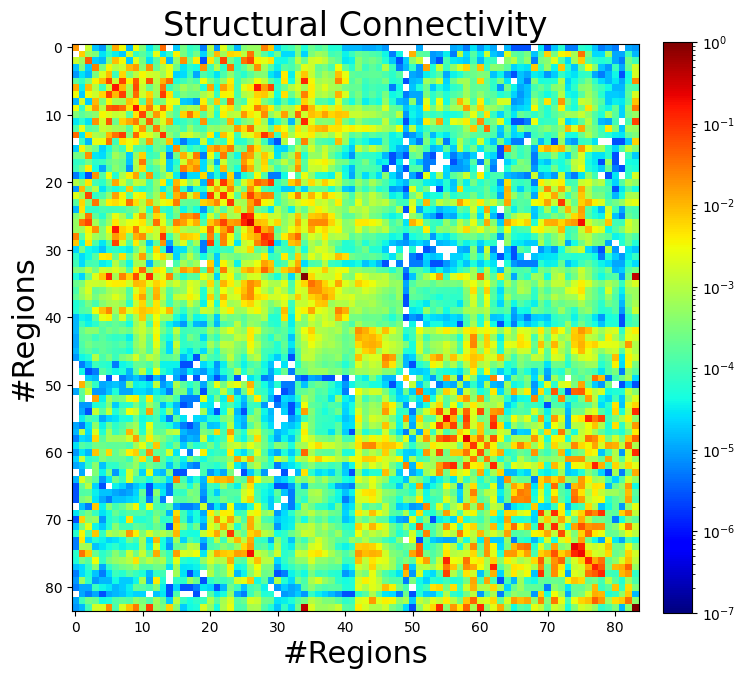

In [20]:
Res_dir = 'results'

results_path = os.path.join(cwd, Res_dir)
os.makedirs(results_path, exist_ok=True)

plt.figure(figsize=(8, 8))
norm = colors.LogNorm(1e-7, weights.max())
im = plt.imshow(weights, norm=norm, cmap=cm.jet)
plt.colorbar(im, fraction=0.046, pad=0.04)
plt.gca().set_title('Structural Connectivity', fontsize=24.0)
plt.ylabel('#Regions', fontsize=22.0)
plt.xlabel('#Regions', fontsize=22.0)

plt.savefig(os.path.join(results_path, "SCMatrix.png"), dpi=800)
plt.savefig(os.path.join(results_path, "SCMatrix.svg"), dpi=800)
plt.show()


## ROIs chosen as Epileptogenic/propagation zones

In [21]:
hz_val=-3.65
pz_val=-2.4
ez_val=-1.6

ez_idx = np.array([6, 34],  dtype=np.int32)
pz_wplng_idx = np.array([5,11], dtype=np.int32)
pz_kplng_idx = np.array([27], dtype=np.int32)
pz_idx = np.append(pz_kplng_idx, pz_wplng_idx)

In [22]:
#Here, confidential medical information
weights[np.ix_(pz_kplng_idx, ez_idx)] = 4.0
weights[np.ix_(pz_wplng_idx, ez_idx)] = 1.0

weights[np.diag_indices(weights.shape[0])] = 0

In [23]:
SC=weights
SC.shape

(84, 84)

### Simulator

In [24]:
from BVEP_Simulator import VEP2Dmodel

### some simulations for  sanity check

In [25]:
T = 14.0
dt=0.1
ts = np.arange(0, T + dt, dt)

In [26]:
nt=ts.shape[0]
nt

141

In [27]:
nn=SC.shape[0]
nn

84

In [28]:
ns=nn
ns

84

In [29]:
tau=10.
sigma=0*10e-1
constants = np.array([tau, sigma])
constants

array([10.,  0.])

In [30]:
eta_true = np.ones(nn)*hz_val
eta_true[ez_idx] = ez_val
eta_true[pz_idx] = pz_val

In [31]:
K_true=1.

In [32]:
x_init=-2.5
z_init=3.5
init_conditions = np.array([x_init, z_init])

In [33]:
params_true = np.append(eta_true, K_true)
params_true.shape

(85,)

In [34]:
start_time = time.time()
Sim = VEP2Dmodel(params_true, constants, init_conditions, dt, ts, SC)
print(" single sim (sec) takes:" , (time.time() - start_time))

 single sim (sec) takes: 4.713243246078491


In [35]:
start_time = time.time()
Sim = VEP2Dmodel(params_true, constants, init_conditions, dt, ts, SC)
print(" single sim (sec) takes:" , (time.time() - start_time))

 single sim (sec) takes: 0.0033147335052490234


In [36]:
X=Sim.reshape(nn, int(Sim.shape[0]/nn))
X.shape

(84, 141)

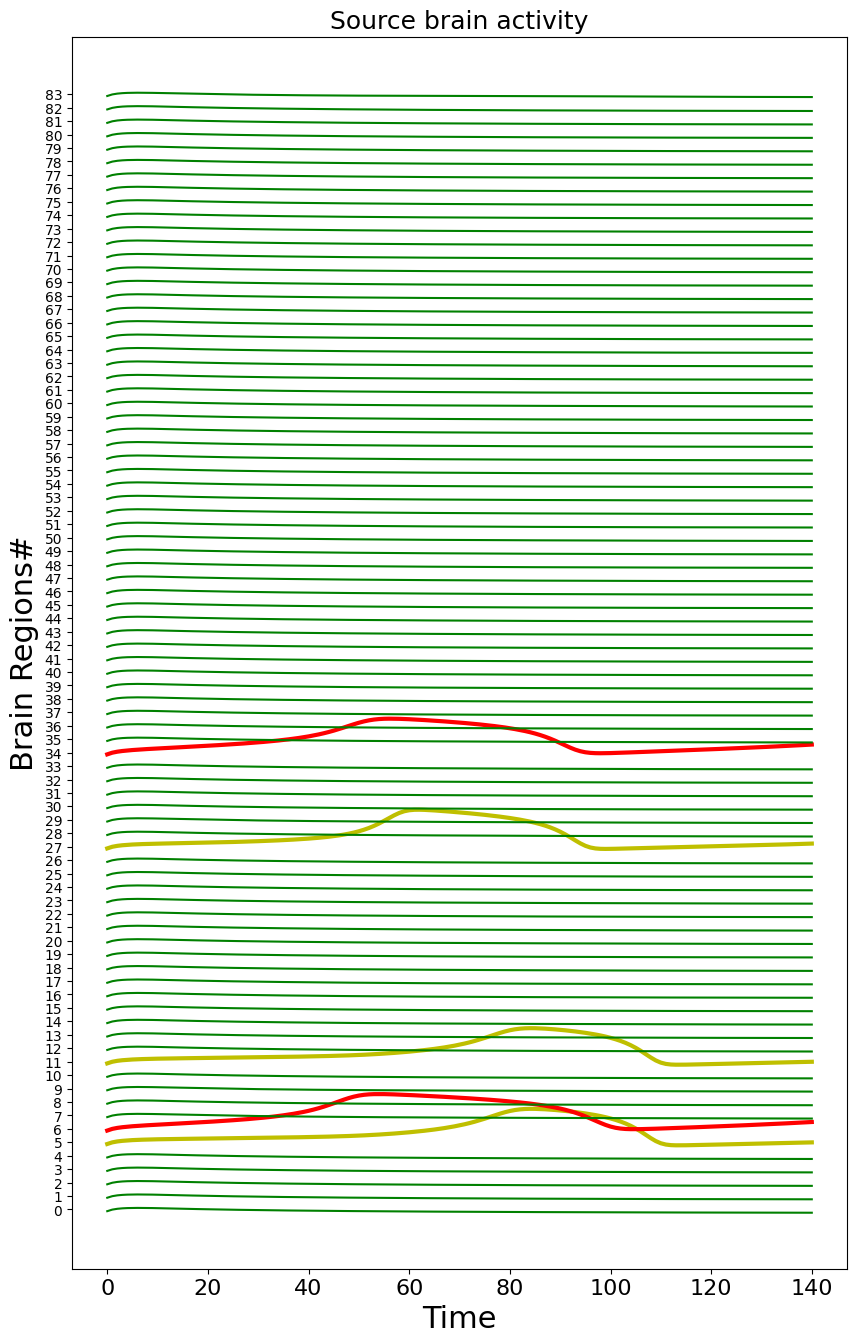

In [37]:
plt.figure(figsize=(10,16))
for i in range(0, nn):
    if i in ez_idx:
          plt.plot(X[i,:]+i, 'r', lw=3)
    elif i in pz_idx:
          plt.plot(X[i,:]+i, 'y', lw=3)
    else:
          plt.plot(X[i,:]+i, 'g')
plt.yticks(np.r_[0:nn]-2, np.r_[0:nn],fontsize=10)
plt.xticks(fontsize=16)
plt.title("Source brain activity",fontsize=18)
plt.xlabel('Time',fontsize=22)
plt.ylabel('Brain Regions#',fontsize=22)
plt.show()

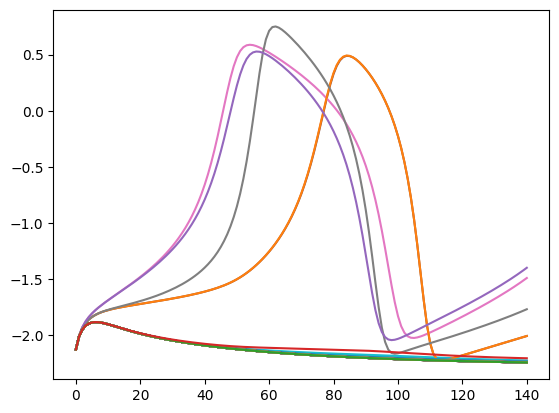

In [38]:
plt.plot(X.T);

### Data features

In [39]:
X.shape

(84, 141)

In [40]:
X_area = np.trapz(X, dx=0.0001)
X_area.shape

(84,)

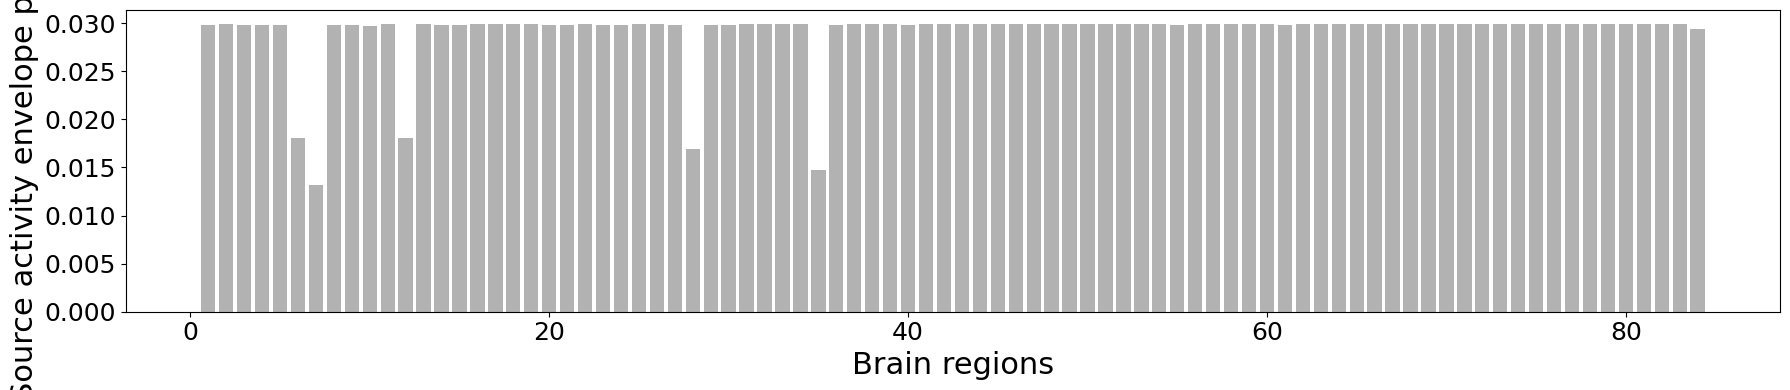

In [41]:
plt.figure(figsize=(18, 4))
plt.bar(np.arange(1,X_area.shape[0]+1), -X_area, color='black', alpha=0.3);
plt.xlabel('Brain regions', fontsize=22)
plt.ylabel('Source activity envelope power', fontsize=22)
plt.yticks(fontsize=18, rotation=0)
plt.xticks(fontsize=18, rotation=0)
plt.tight_layout()
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"Source_envelop_power.png"), dpi=800)
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"Source_envelop_power.svg"), dpi=800)
plt.show()

In [42]:
X_pwr = np.sum((X*X), axis=1)
X_pwr_n = 1-(X_pwr/ X_pwr.max())

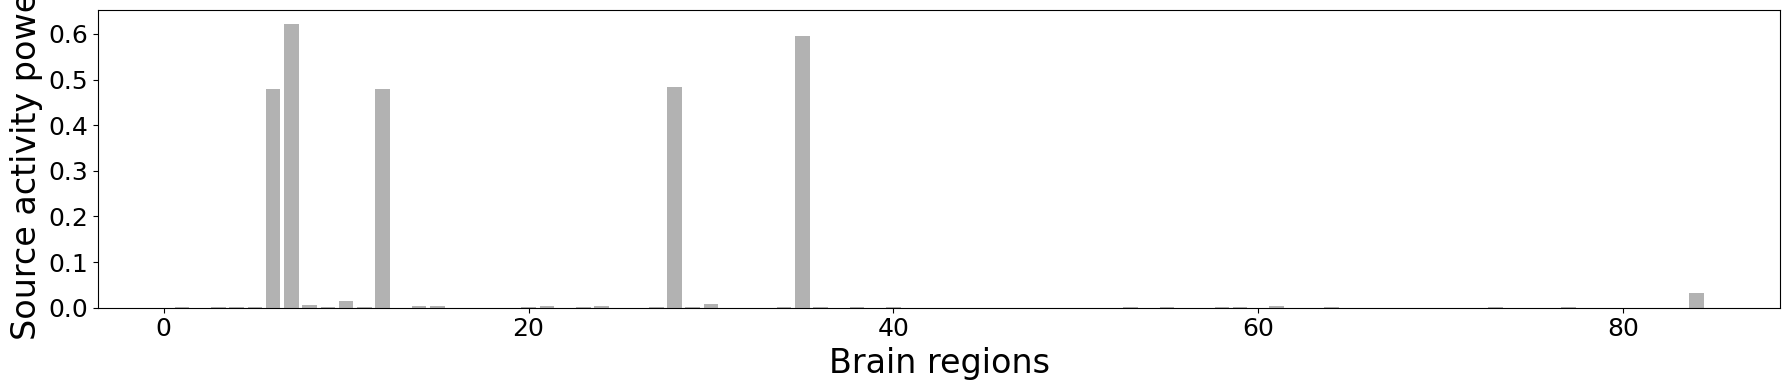

In [43]:
plt.figure(figsize=(18, 4))
plt.bar(np.arange(1,X_pwr.shape[0]+1), X_pwr_n, color='black', alpha=0.3);
plt.xlabel('Brain regions', fontsize=24)
plt.ylabel('Source activity power', fontsize=24)
plt.yticks(fontsize=18, rotation=0)
plt.xticks(fontsize=18, rotation=0)
plt.tight_layout()
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"Source_envelop_power_normalize.png"), dpi=800)
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"Source_envelop_power_normalize.svg"), dpi=800)
plt.show()

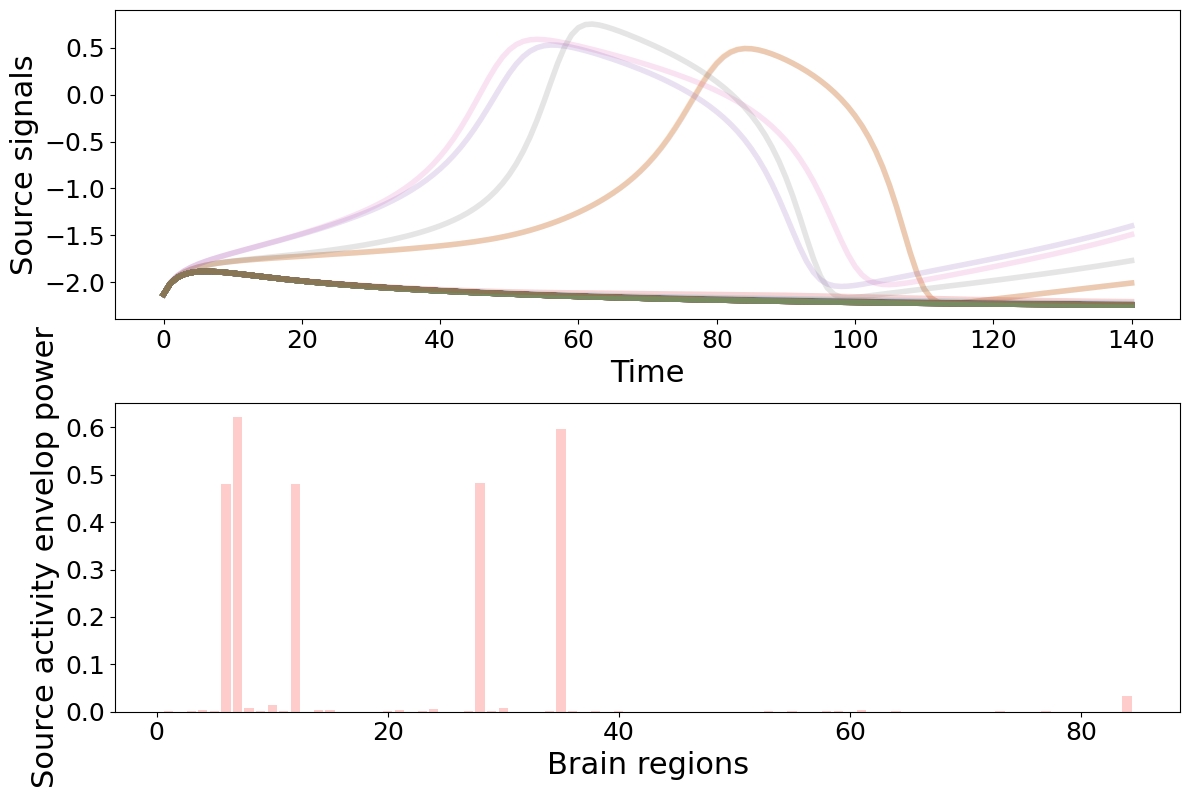

In [44]:
plt.figure(figsize=(12,8))
plt.subplot(211)
plt.plot(X.T, linewidth=4, alpha=0.2);
plt.xlabel('Time', fontsize=22)
plt.ylabel('Source signals', fontsize=22)
plt.yticks(fontsize=18, rotation=0)
plt.xticks(fontsize=18, rotation=0)

plt.subplot(212)
plt.bar(np.arange(1,X_pwr_n.shape[0]+1), X_pwr_n, color='r', alpha=0.2)
#plt.bar(np.arange(1,Seeg_area.shape[0]+1), Seeg_area, color='black', alpha=0.3);
plt.xlabel('Brain regions', fontsize=22)
plt.ylabel('Source activity envelop power', fontsize=22)
plt.yticks(fontsize=18, rotation=0)
plt.xticks(fontsize=18, rotation=0)
plt.tight_layout()
plt.show()

In [45]:
from BVEP_stat_summary import calculate_summary_statistics_features

In [47]:
nn, ns, nt

(84, 84, 141)

In [46]:
_=calculate_summary_statistics_features(X.reshape(-1), nn, nt, dt, ts, features=['seizures_onset'])
num_features=_.shape[0]
print('feature shape:', num_features)

feature shape: 588


In [48]:
num_params=nn+1
num_params

85

### 1. Simulator wrapper

In [49]:
def VEP2Dmodel_source_simulator_wrapper(params):

    params = np.asarray(params)

    # time step
    T = 14.0
    dt=0.1
    ts = np.arange(0, T + dt, dt)

    # fixed parameters
    tau=10. #will not be fixed in the second iteration, goal is to find ideal tau
    sigma=0*10e-1
    constants = np.array([tau, sigma])

    nn=SC.shape[0]
    ns=nn
    nt=ts.shape[0]

    # initial conditions
    x_init=-2.5
    z_init=3.5
    init_conditions = np.array([x_init, z_init])

    Sim = VEP2Dmodel(params, constants, init_conditions, dt, ts, SC)

    #Source_signal=Sim.reshape(nn, int(Sim.shape[0]/nn))

    #summstats = torch.as_tensor(calculate_summary_statistics_features(Source_signal.reshape(-1),  nn, nt, dt, ts, features=['seizures_onset']))

    return Sim


### 2. Prior over model parameters

In [50]:
nn+1

85

In [51]:
prior_min_eta=-5*np.ones(nn)
prior_min_K=0*np.ones(1)

prior_max_eta=-1*np.ones(nn)
prior_max_K=2*np.ones(1)

In [52]:
prior_min=np.append(prior_min_eta, prior_min_K)
prior_max=np.append(prior_max_eta, prior_max_K)

In [53]:
prior_min.shape, prior_max.shape

((85,), (85,))

In [54]:
prior = BoxUniform(low=torch.tensor(prior_min),
                   high=torch.tensor(prior_max))


In [55]:
prior.sample().shape, prior.batch_shape, prior.event_shape

(torch.Size([85]), torch.Size([]), torch.Size([85]))

### 3. Simulation and inference

In [56]:
num_sim=10000

In [ ]:
# start_time = time.time()

# posterior = infer(VEP2Dmodel_source_simulator_wrapper, prior, method='SNPE',  num_simulations=10000, num_workers=1)

# print ("-"*60)
# print("--- %s seconds ---" % (time.time() - start_time))

In [57]:
mysavepath = '/content/BVEP/SBI/results/simulated_theta_x.npz'
mysavepath

'/content/BVEP/SBI/results/simulated_theta_x.npz'

In [58]:
# def save_sims(simulator: Callable, prior, mysavepath, num_simulations: int):

#     simulator, prior = prepare_for_sbi(simulator, prior)

#     theta, x = simulate_for_sbi(
#         simulator=simulator,
#         proposal=prior,
#         num_simulations=num_simulations,
#         show_progress_bar=True,)

#     #print(theta,flush=True)
#     print( 'theta shape:',theta.shape,flush=True)
#     #print(x,flush=True)
#     print('data shape:', x.shape,flush=True)

#     np.savez(mysavepath,theta=theta,x=x)
#ABOVE IS. DEPRECATED

#NEW without using simulate_for_sbi or prepare_for_sbi

#Question: is this correct? I am trying to recreate the above but SBI has changed
def save_sims(simulator: Callable, prior, mysavepath, num_simulations: int):
    # Sample parameters from prior
    theta = prior.sample((num_simulations,))

    # Run simulator for each theta
    # Convert output to tensor if needed
    x = torch.stack([torch.tensor(simulator(t)) for t in theta])

    print('theta shape:', theta.shape)
    print('data shape:', x.shape)

    # Save to npz file (convert tensors to numpy arrays)
    np.savez(mysavepath, theta=theta.numpy(), x=x.numpy())


In [59]:
# start_time = time.time()

# save_sims(VEP2Dmodel_source_simulator_wrapper, prior, mysavepath, num_simulations=1)

# print ("-"*60)
# print("--- one sim took: %s seconds ---" % (time.time() - start_time))
#ABOVE IS DEPRECATED

#NEW
import time

start_time = time.time()

save_sims(VEP2Dmodel_source_simulator_wrapper, prior, mysavepath, num_simulations=1)

print("-" * 60)
print(f"--- one sim took: {time.time() - start_time} seconds ---")

theta shape: torch.Size([1, 85])
data shape: torch.Size([1, 11844])
------------------------------------------------------------
--- one sim took: 2.548281192779541 seconds ---


In [60]:
start_time = time.time()

save_sims(VEP2Dmodel_source_simulator_wrapper, prior, mysavepath, num_simulations=1)

print ("-"*60)
print("--- one sim with JIT took: %s seconds ---" % (time.time() - start_time))

theta shape: torch.Size([1, 85])
data shape: torch.Size([1, 11844])
------------------------------------------------------------
--- one sim with JIT took: 0.016024112701416016 seconds ---


In [61]:
start_time = time.time()

save_sims(VEP2Dmodel_source_simulator_wrapper, prior, mysavepath, num_simulations=num_sim)

print ("-"*60)
print("---all simulations took:  %s seconds ---" % (time.time() - start_time))

theta shape: torch.Size([10000, 85])
data shape: torch.Size([10000, 11844])
------------------------------------------------------------
---all simulations took:  48.51381278038025 seconds ---


### Load simulations and calculate features

In [62]:
sim_deja=np.load(mysavepath)

In [63]:
theta_deja=sim_deja['theta']
x_deja=sim_deja['x']

In [64]:
print( 'theta shape:',theta_deja.shape,flush=True)
print('data shape:', x_deja.shape,flush=True)

theta shape: (10000, 85)
data shape: (10000, 11844)


In [65]:
x_deja_features=np.zeros((num_sim,num_features))
theta_deja_features=np.zeros((num_sim,num_params))

In [66]:
print( 'theta shape:',theta_deja_features.shape,flush=True)
print('data frature shape:', x_deja_features.shape,flush=True)

theta shape: (10000, 85)
data frature shape: (10000, 588)


In [67]:
start_time = time.time()

for i in range(num_sim):
    theta_deja_features[i,:]=theta_deja[i,:]
    x_deja_features[i,:]=calculate_summary_statistics_features(x_deja[i,:].reshape(-1), nn, nt, dt, ts, features=['seizures_onset'])

print ("-"*60)
print("---feature calculation took:  %s seconds ---" % (time.time() - start_time))

------------------------------------------------------------
---feature calculation took:  29.64958691596985 seconds ---


In [68]:
print( 'theta deja shape:',theta_deja_features.shape,flush=True)
print('data deja feature shape:', x_deja_features.shape,flush=True)

theta deja shape: (10000, 85)
data deja feature shape: (10000, 588)


In [69]:
np.isnan(np.sum(x_deja_features))

np.False_

In [70]:
x = np.array(x_deja_features, dtype='float32')
x     = torch.as_tensor(x)

theta = np.array(theta_deja_features, dtype='float32')
theta = theta.reshape(theta.shape[0],num_params)
theta = torch.as_tensor(theta)

In [71]:
print( 'theta shape:',theta.shape,flush=True)
print('data feature shape:', x.shape,flush=True)

theta shape: torch.Size([10000, 85])
data feature shape: torch.Size([10000, 588])


### Inference

In [74]:
def myinfer_SNPE(prior, theta, x):
    inference = SNPE(prior, density_estimator='maf')
    _ = inference.append_simulations(theta, x).train()
    posterior = inference.build_posterior(sample_with='direct')
    #due to error
    #ValueError: You passed `sample_with='rejection' but you did not specify a `proposal` in `rejection_sampling_parameters`. Until sbi v0.22.0, this was interpreted as directly sampling from the posterior. As of sbi v0.23.0, you instead have to use `sample_with='direct'` to do so.
    return posterior


In [75]:
start_time = time.time()

posterior = myinfer_SNPE(prior, theta, x)

print ("-"*60)
print("--- Training neural network took: %s seconds ---" % (time.time() - start_time))

 Neural network successfully converged after 661 epochs.------------------------------------------------------------
--- Training neural network took: 673.0637392997742 seconds ---


### Data

In [76]:
obs_source =VEP2Dmodel(params_true, constants, init_conditions, dt, ts, SC)
obs_source=obs_source.reshape(nn, int(obs_source.shape[0]/nn))

In [77]:
obs_summary_statistics=calculate_summary_statistics_features(obs_source.reshape(-1),  nn, nt, dt, ts, features=['seizures_onset'])

In [78]:
obs_source.shape, obs_summary_statistics.shape

((84, 141), (588,))

In [79]:
y_obs=obs_source
y_obs.shape

(84, 141)

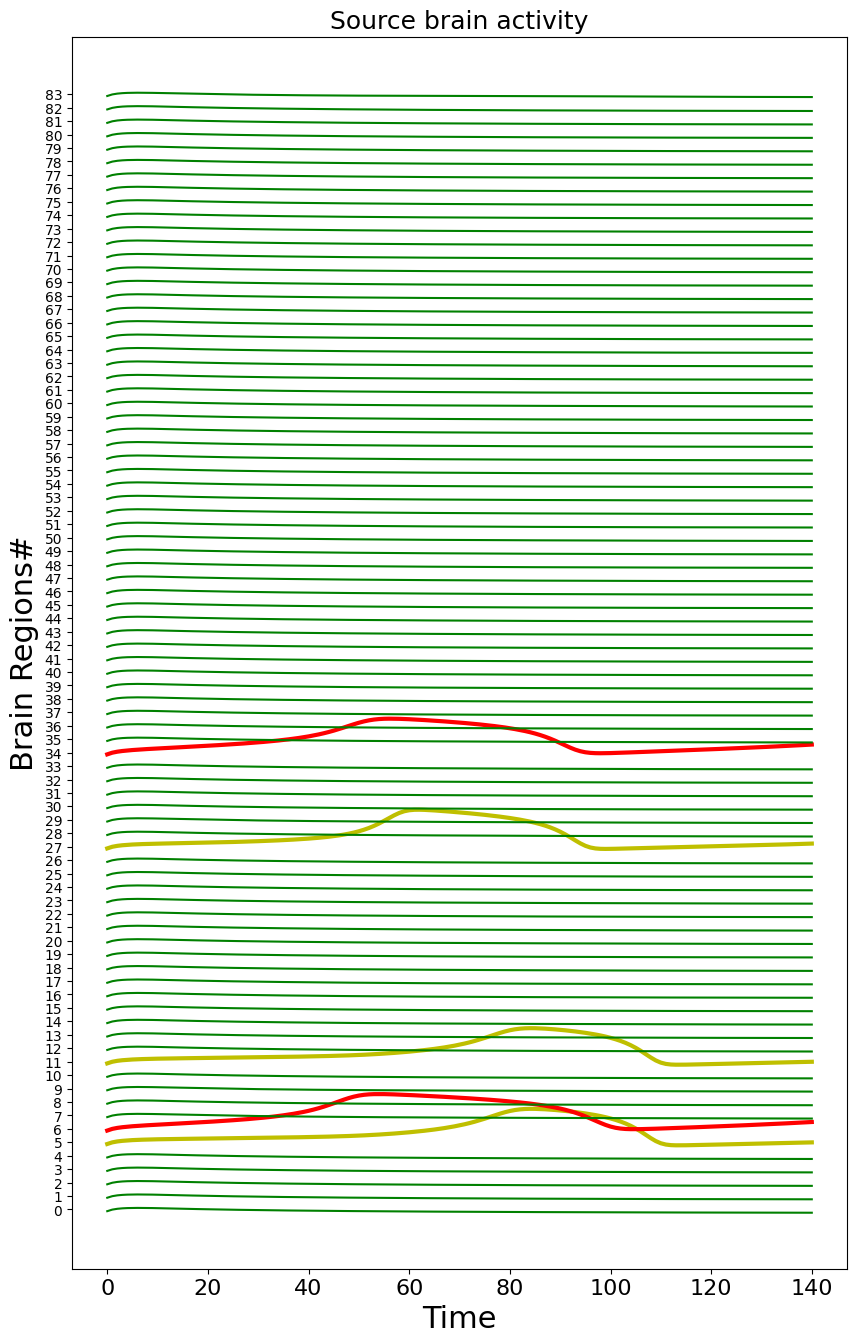

In [80]:
plt.figure(figsize=(10,16))
for i in range(0, nn):
    if i in ez_idx:
          plt.plot(obs_source[i,:]+i, 'r', lw=3)
    elif i in pz_idx:
          plt.plot(obs_source[i,:]+i, 'y', lw=3)
    else:
          plt.plot(obs_source[i,:]+i, 'g')
plt.yticks(np.r_[0:nn]-2, np.r_[0:nn],fontsize=10)
plt.xticks(fontsize=16)
plt.title("Source brain activity",fontsize=18)
plt.xlabel('Time',fontsize=22)
plt.ylabel('Brain Regions#',fontsize=22)
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"SBI_BVEP_ode_obs_source_K_"+str(K_true)+".png"), dpi=800)
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"SBI_BVEP_ode_obs_source_K_"+str(K_true)+".svg"), dpi=800)
plt.show()

### Posterior

In [81]:
from sklearn.metrics import confusion_matrix
from BVEP_SME import SME_labels, SEM_violinplot, plot_confusion_matrix, plot_zscore_shrinkage, plot_roc_curve, true_node_binary, estimated_node_binary, SME_accuracy

In [82]:
nodes=np.r_[0:nn]

In [83]:
num_samples=200

In [84]:
start_time = time.time()

posterior_samples = posterior.sample((num_samples,), obs_summary_statistics).numpy()

print ("-"*60)
print("--- sampling took: %s seconds ---" % (time.time() - start_time))

Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

------------------------------------------------------------
--- sampling took: 0.8101096153259277 seconds ---


In [85]:
posterior_samples.shape, params_true.shape

((200, 85), (85,))

In [86]:
np.save(os.path.join(cwd+'/'+str(Res_dir), 'BVEP_ode_sbi_sourcelevel_patient1_posteriorsamples.npy') , posterior_samples)

In [87]:
eta_posterior=posterior_samples[:,:-1]
K_posterior=posterior_samples[:,-1]

In [88]:
K_posterior.mean(), K_posterior.std()

(np.float32(1.0894256), np.float32(0.40543392))

In [89]:
eta_c=-1.95
delta_eta=1.0

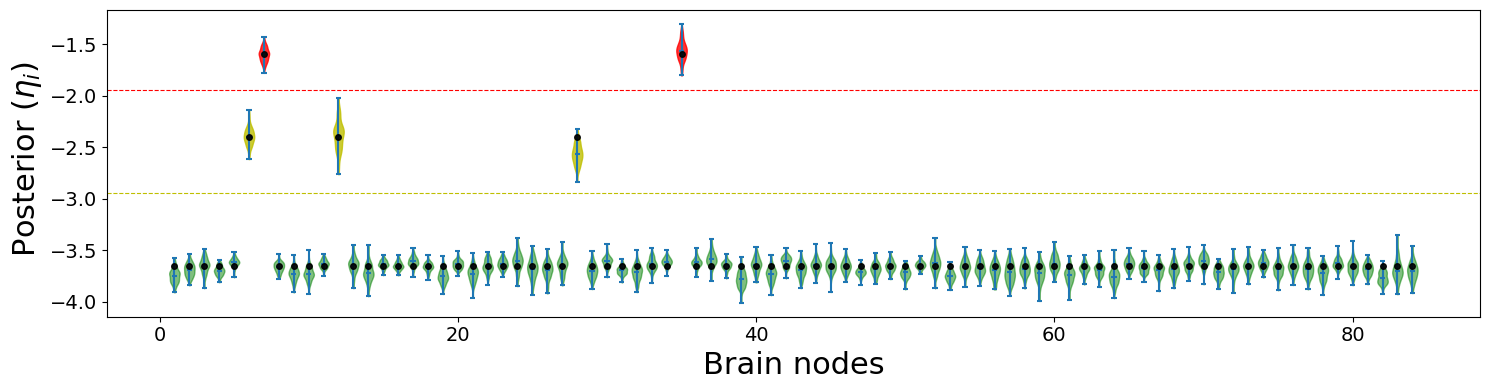

In [90]:
plt.figure(figsize=(15,4))
SEM_violinplot(nn, eta_true, ez_idx, pz_idx, eta_posterior, eta_c, delta_eta )
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"SBI_BVEP_ode_InferredExcitability_K_"+str(K_true)+".png"), dpi=800)
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"SBI_BVEP_ode_InferredExcitability_K_"+str(K_true)+".svg"), dpi=800)
plt.show()

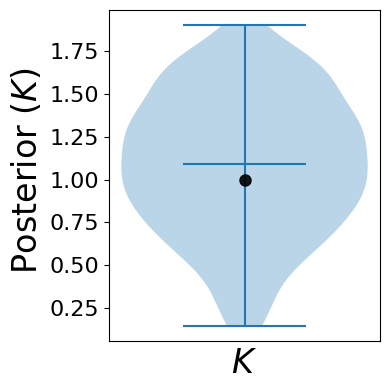

In [91]:
plt.figure(figsize=(4,4))
parts= plt.violinplot(K_posterior, widths=0.7, showmeans=True, showextrema=True);
plt.plot(1,params_true[-1] ,'o', color='k', alpha=0.9, markersize=8)
plt.ylabel(' Posterior ' +r'${(K)}$', fontsize=24);
plt.xlabel(r'${K}$', fontsize=24);
plt.yticks(fontsize=16)
plt.xticks([])
plt.tight_layout()
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"SBI_BVEP_ode_InferredCoupling_K_"+str(K_true)+".png"), dpi=800)
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"SBI_BVEP_ode_InferredCoupling_K_"+str(K_true)+".svg"), dpi=800)
plt.show()

In [92]:
estimated_posterior=np.percentile(posterior_samples, [50], axis=0).reshape(-1)

In [93]:
y_fit_source =VEP2Dmodel(estimated_posterior, constants, init_conditions, dt, ts, SC)

yfit_source=y_fit_source.reshape(nn, int(y_fit_source.shape[0]/nn))

In [94]:
y_fit=yfit_source
y_fit.shape

(84, 141)

In [95]:
np.save(os.path.join(cwd+'/'+str(Res_dir), 'BVEP_ode_sbi_sourcelevel_patient1_y_obs.npy') , y_obs)
np.save(os.path.join(cwd+'/'+str(Res_dir), 'BVEP_ode_sbi_sourcelevel_patient1_y_fit.npy') , y_fit)

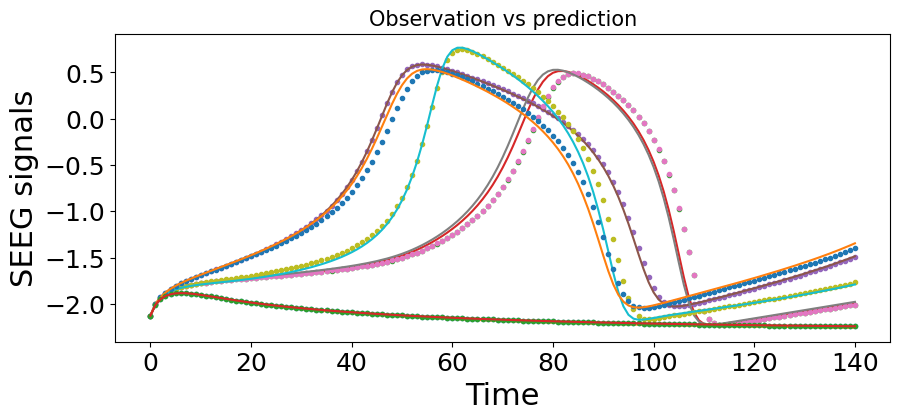

In [96]:
Rois=np.array([1, 5, 6, 11, 27, 34, 50])

plt.figure(figsize=(10,4))
for roi in Rois:
    plt.plot(y_obs.T[:,roi], '.')
    plt.plot(y_fit.T[:,roi] )
plt.title("Observation vs prediction",fontsize=15)
plt.xlabel('Time', fontsize=22)
plt.ylabel('SEEG signals', fontsize=22)
plt.yticks(fontsize=18, rotation=0)
plt.xticks(fontsize=18, rotation=0)
plt.show()

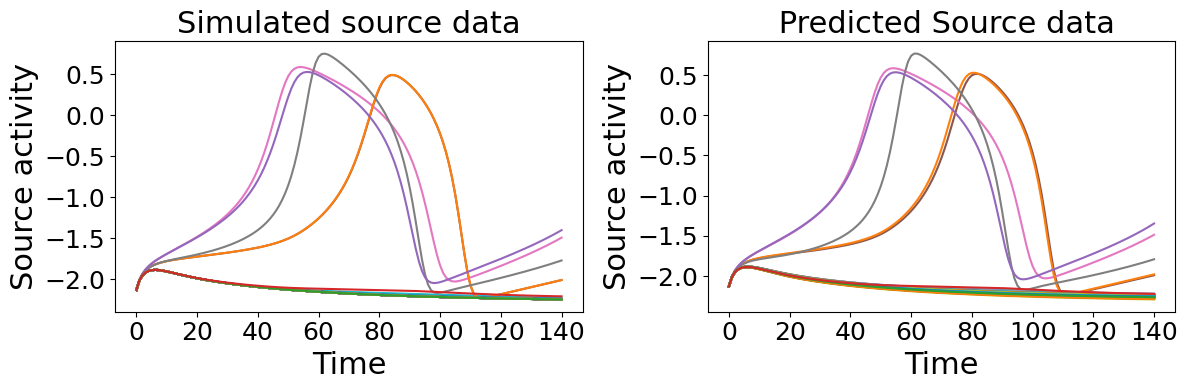

In [97]:
plt.figure(figsize=(12,4))

plt.subplot(121);
plt.plot(y_obs.T)
plt.title("Simulated source data", fontsize=22)
plt.xlabel('Time', fontsize=22)
plt.ylabel('Source activity', fontsize=22)
plt.yticks(fontsize=18, rotation=0)
plt.xticks(fontsize=18, rotation=0)

plt.subplot(122)
plt.plot(y_fit.T)
plt.title(" Predicted Source data", fontsize=22)
plt.xlabel('Time', fontsize=22)
plt.ylabel('Source activity', fontsize=22)
plt.yticks(fontsize=18, rotation=0)
plt.xticks(fontsize=18, rotation=0)
plt.tight_layout()
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"SBI_FittedBVEP_ode_observation_K_"+str(K_true)+".png"), dpi=800)
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"SBI_FittedBVEP_ode_observation_K_"+str(K_true)+".svg"), dpi=800)
plt.show()

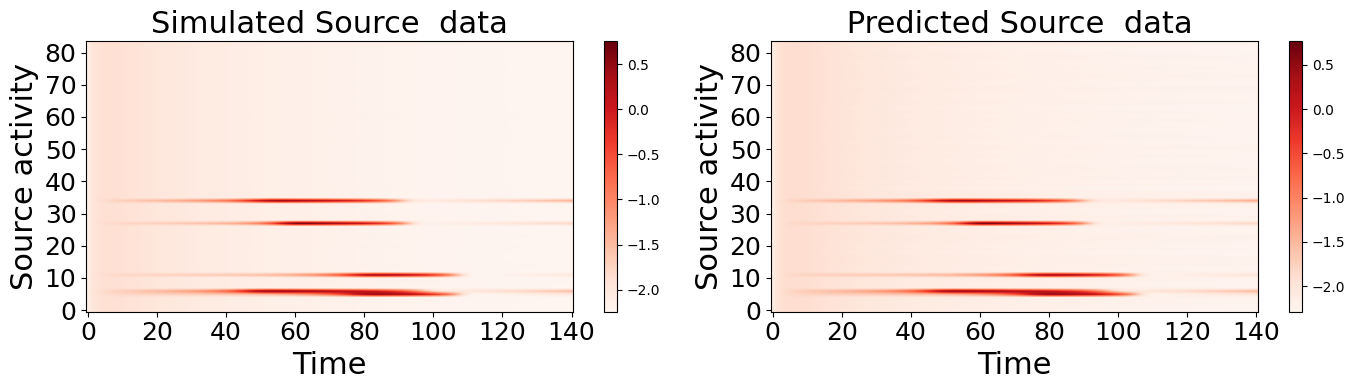

In [98]:
plt.figure(figsize=(14, 4))
plt.subplot(121);
plt.imshow(y_obs, aspect='auto', interpolation='bilinear',  origin='lower', cmap='Reds')
plt.title("Simulated Source  data", fontsize=22)
plt.xlabel('Time', fontsize=22)
plt.ylabel('Source activity', fontsize=22)
plt.yticks(fontsize=18, rotation=0)
plt.xticks(fontsize=18, rotation=0)
plt.colorbar();

plt.subplot(122)
plt.imshow(y_fit, aspect='auto', interpolation='bilinear',  origin='lower', cmap='Reds')
plt.title(" Predicted Source  data", fontsize=22)
plt.xlabel('Time', fontsize=22)
plt.ylabel('Source activity', fontsize=22)
plt.yticks(fontsize=18, rotation=0)
plt.xticks(fontsize=18, rotation=0)
plt.colorbar();

plt.tight_layout()
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"SBI_ImshowFittedBVEP_ode_observation_K_"+str(K_true)+".png"), dpi=800)
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"SBI_ImshowFittedBVEP_ode_observation_K_"+str(K_true)+".svg"), dpi=800)
plt.show()

In [99]:
eta_true.shape, eta_posterior.shape

((84,), (200, 84))

In [100]:
true_labels_nodes,est_labels_nodes =SME_labels(eta_true, eta_posterior.transpose(), eta_c, delta_eta)

In [101]:
Confusion_matrix_values= confusion_matrix(true_labels_nodes, est_labels_nodes, labels=["EZ", "PZ", "HZ"])
print('Confusion_matrix_values= \n', Confusion_matrix_values)

Confusion_matrix_values= 
 [[ 2  0  0]
 [ 0  3  0]
 [ 0  0 79]]


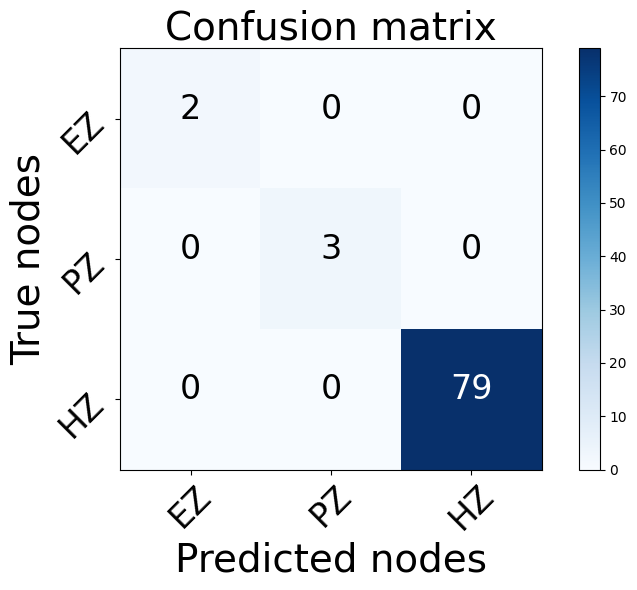

In [102]:
plt.figure(figsize=(8, 6))
plot_confusion_matrix(Confusion_matrix_values, ["EZ", "PZ", "HZ"])
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"SBI_BVEP_ode_ConfusionMatrix_K_"+str(K_true)+".png"), dpi=800)
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"SBI_BVEP_ode_ConfusionMatrix_K_"+str(K_true)+".svg"), dpi=800)
plt.tight_layout()
plt.show()

In [103]:
np.sum(np.std(eta_posterior, axis=0))

np.float32(5.4595942)

In [104]:
from report_metrics import LSE, Err, RMSE, LSE_obs, z_score, shrinkage

In [105]:
eta_est_mu=np.mean(eta_posterior, axis=0)
eta_est_std=np.std(eta_posterior, axis=0)

In [106]:
b=-7
a=-1
prior_std =np.sqrt((1/12)*(b-a)**2)

In [107]:
def plot_zscore_shrinkage(nodes, eta_true, eta_est_mu, eta_est_std, prior_std):
    z_score_eta=z_score(eta_true, eta_est_mu, eta_est_std)
    colors= np.random.rand(z_score_eta.shape[0])
    plt.scatter(shrinkage([prior_std]*nodes.shape[0], eta_est_std), z_score_eta ,s=120, c='blue')
    plt.xlabel("Posterior shrinkages", fontsize=24)
    plt.ylabel("Posterior z-scores", fontsize=24)
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)

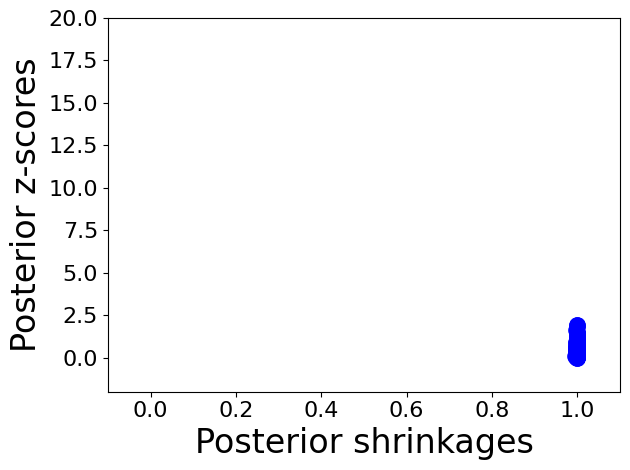

In [108]:
plot_zscore_shrinkage(nodes, eta_true, eta_est_mu, eta_est_std, prior_std)
plt.axis((-.1,1.1,-2,20))
plt.tight_layout()
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"SBI_BVEP_ode_zscore_shrinkage_K_"+str(K_true)+".png"), dpi=800)
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"SBI_BVEP_ode_zscore_shrinkage_K_"+str(K_true)+".svg"), dpi=800)
plt.show()

In [109]:
Err(eta_true, eta_est_mu), RMSE(eta_true, eta_est_mu)

(np.float64(3.350987601280215), np.float64(0.05241758335767698))

In [110]:
Err(y_obs, y_fit), RMSE(y_obs, y_fit)

(np.float64(152.85536972328956), np.float64(0.03039235880248905))

In [111]:
shrinkage([prior_std]*nodes.shape[0], eta_est_std).shape

(84,)

In [112]:
from sklearn import metrics
from itertools import cycle
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_recall_curve
from sklearn.preprocessing import label_binarize

In [113]:
n_classes=3
node_classes=['HZ', 'PZ', 'EZ']

In [114]:
true_nodes=true_node_binary(true_labels_nodes)
estimated_nodes=estimated_node_binary(est_labels_nodes)

In [115]:
y_true=label_binarize(true_nodes, classes=[0, 1, 2])
y_pred=label_binarize(estimated_nodes, classes=[0, 1, 2])

In [116]:
y_true.shape, y_pred.shape

((84, 3), (84, 3))

In [117]:
fpr = dict()
tpr = dict()
roc_auc = dict()


for i in range(n_classes):
    fpr[i], tpr[i], _ = metrics.roc_curve(y_true[:, i], y_pred[:, i])
    roc_auc[i] = metrics.auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = metrics.roc_curve(y_true.ravel(), y_pred.ravel())
roc_auc["micro"] = metrics.auc(fpr["micro"], tpr["micro"])


all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = metrics.auc(fpr["macro"], tpr["macro"])

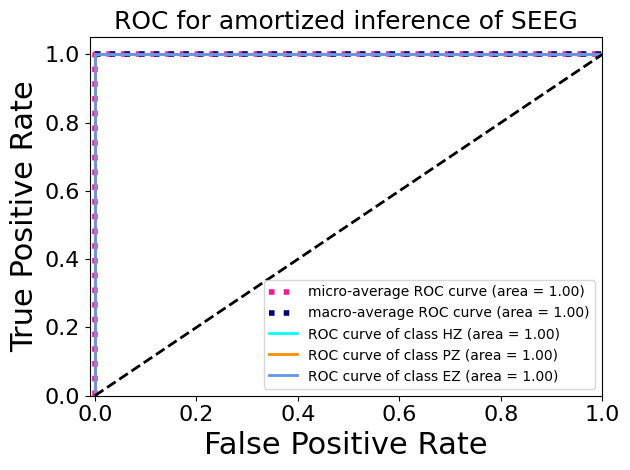

In [118]:
# Plot all ROC curves
plt.figure()

plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
lw=2

for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class '+ str(node_classes[i])+' (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([-.01, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=22)
plt.ylabel('True Positive Rate', fontsize=22)
plt.title('ROC for amortized inference of SEEG', fontsize=18)
plt.legend(loc="lower right")
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.tight_layout()
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"ROC_K_"+str(K_true)+".png"), dpi=800)
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"ROC_K_"+str(K_true)+".png"), dpi=800)
plt.show()

In [119]:
fpr

{0: array([0., 0., 1.]),
 1: array([0., 0., 1.]),
 2: array([0., 0., 1.]),
 'micro': array([0., 0., 1.]),
 'macro': array([0., 1.])}

In [120]:
tpr

{0: array([0., 1., 1.]),
 1: array([0., 1., 1.]),
 2: array([0., 1., 1.]),
 'micro': array([0., 1., 1.]),
 'macro': array([1., 1.])}

In [121]:
roc_auc["micro"], roc_auc["macro"]

(np.float64(1.0), np.float64(1.0))

### Another Data set

In [122]:
hz_val=-3.65
pz_val=-2.5
ez_val=-1.7


ez_idx = np.array([7, 29],  dtype=np.int32)
pz_wplng_idx = np.array([6, 9, 28], dtype=np.int32)
pz_kplng_idx = np.array([27], dtype=np.int32)
pz_idx = np.append(pz_kplng_idx, pz_wplng_idx)

In [123]:
eta_true = np.ones(nn)*hz_val
eta_true[ez_idx] = ez_val
eta_true[pz_idx] = pz_val

In [124]:
K_true=1.

In [125]:
x_init=-2.5
z_init=3.5
init_conditions = np.array([x_init, z_init])

In [126]:
params_true = np.append(eta_true, K_true)
params_true.shape

(85,)

In [127]:
obs_source =VEP2Dmodel(params_true, constants, init_conditions, dt, ts, SC)
obs_source=obs_source.reshape(nn, int(obs_source.shape[0]/nn))

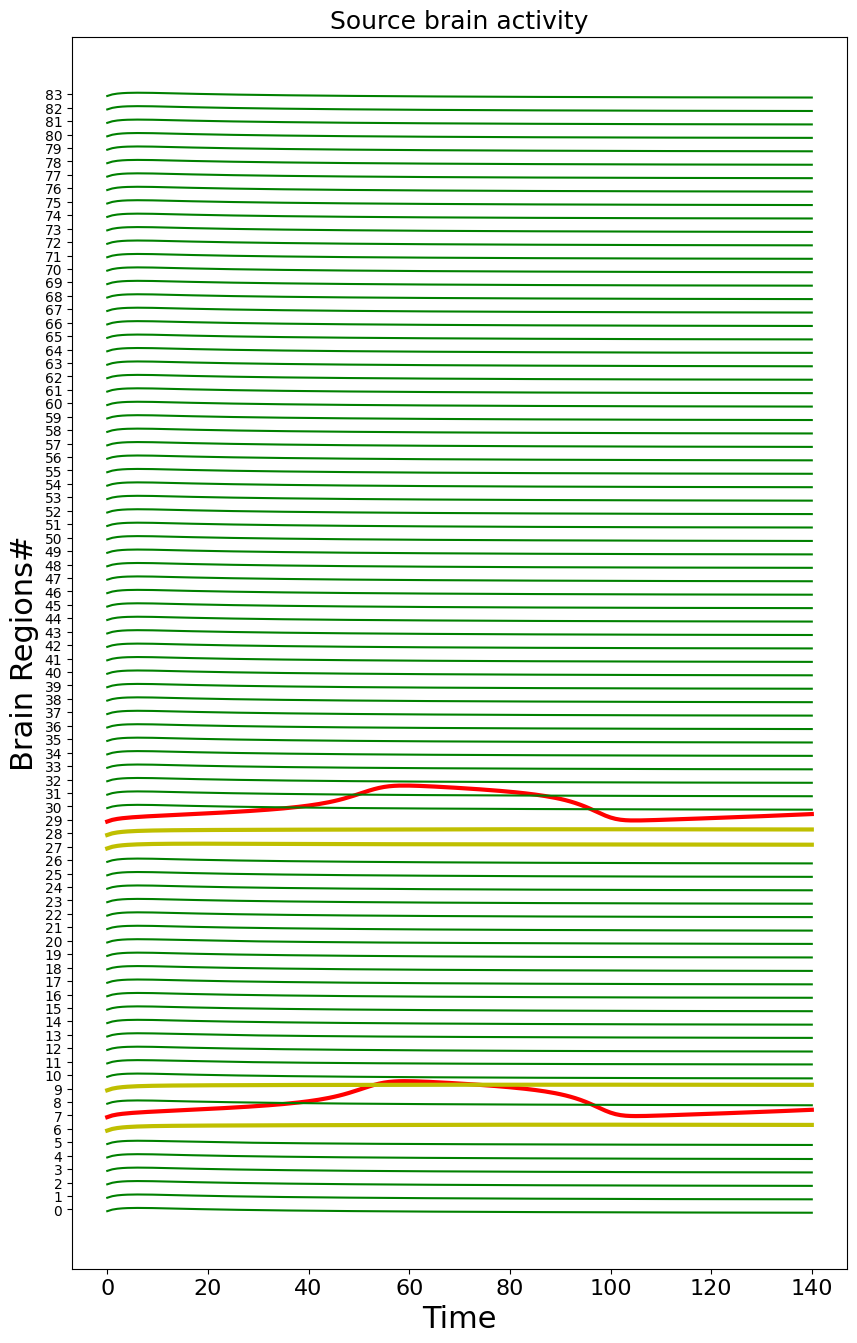

In [128]:
plt.figure(figsize=(10,16))
for i in range(0, nn):
    if i in ez_idx:
          plt.plot(obs_source[i,:]+i, 'r', lw=3)
    elif i in pz_idx:
          plt.plot(obs_source[i,:]+i, 'y', lw=3)
    else:
          plt.plot(obs_source[i,:]+i, 'g')
plt.yticks(np.r_[0:nn]-2, np.r_[0:nn],fontsize=10)
plt.xticks(fontsize=16)
plt.title("Source brain activity",fontsize=18)
plt.xlabel('Time',fontsize=22)
plt.ylabel('Brain Regions#',fontsize=22)
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"SBI_BVEP_ode_obs2_source_K_"+str(K_true)+".png"), dpi=800)
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"SBI_BVEP_ode_obs2_source_K_"+str(K_true)+".svg"), dpi=800)
plt.show()

In [129]:
obs_summary_statistics=calculate_summary_statistics_features(obs_source.reshape(-1),  nn, nt, dt, ts, features=['seizures_onset'])

In [130]:
obs_source.shape, obs_summary_statistics.shape

((84, 141), (588,))

In [131]:
y_obs=obs_source
y_obs.shape

(84, 141)

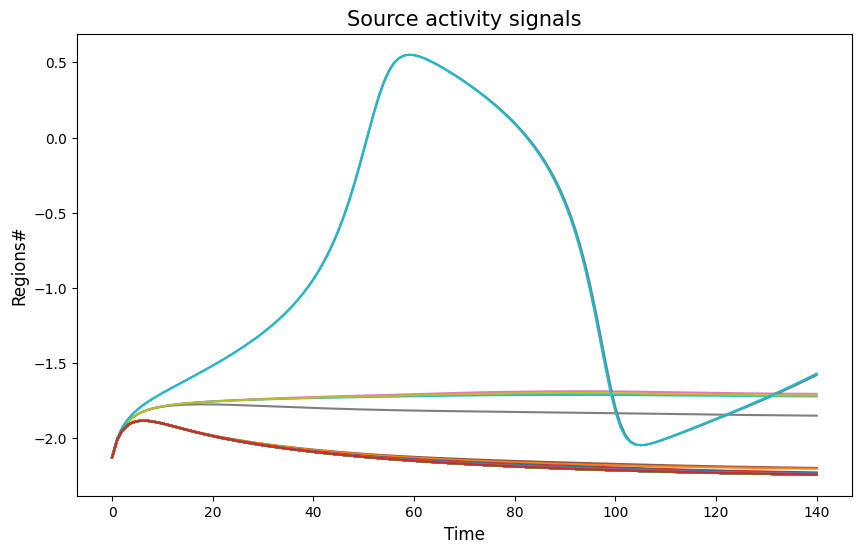

In [132]:
plt.figure(figsize=(10,6))
plt.plot(obs_source.T)
plt.title("Source activity signals",fontsize=15)
plt.xlabel('Time',fontsize=12)
plt.ylabel('Regions#',fontsize=12)
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"SBI_BVEP_ode_obs2_seeg_K_"+str(K_true)+".png"), dpi=800)
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"SBI_BVEP_ode_obs2_seeg_K_"+str(K_true)+".svg"), dpi=800)

### Posterior

In [133]:
nodes=np.r_[0:nn]

In [134]:
num_samples=200

In [135]:
start_time = time.time()

posterior_samples = posterior.sample((num_samples,), obs_summary_statistics).numpy()

print ("-"*60)
print("--- sampling took: %s seconds ---" % (time.time() - start_time))

Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

------------------------------------------------------------
--- sampling took: 0.7777626514434814 seconds ---


In [136]:
posterior_samples.shape, params_true.shape

((200, 85), (85,))

In [137]:
np.save(os.path.join(cwd+'/'+str(Res_dir), 'BVEP_ode_sbi_sourcelevel_obs2_patient1_posteriorsamples.npy') , posterior_samples)

In [138]:
eta_posterior=posterior_samples[:,:-1]
K_posterior=posterior_samples[:,-1]

In [139]:
K_posterior.mean(), K_posterior.std()

(np.float32(1.2764615), np.float32(0.39091238))

In [140]:
eta_c=-1.95
delta_eta=1.0

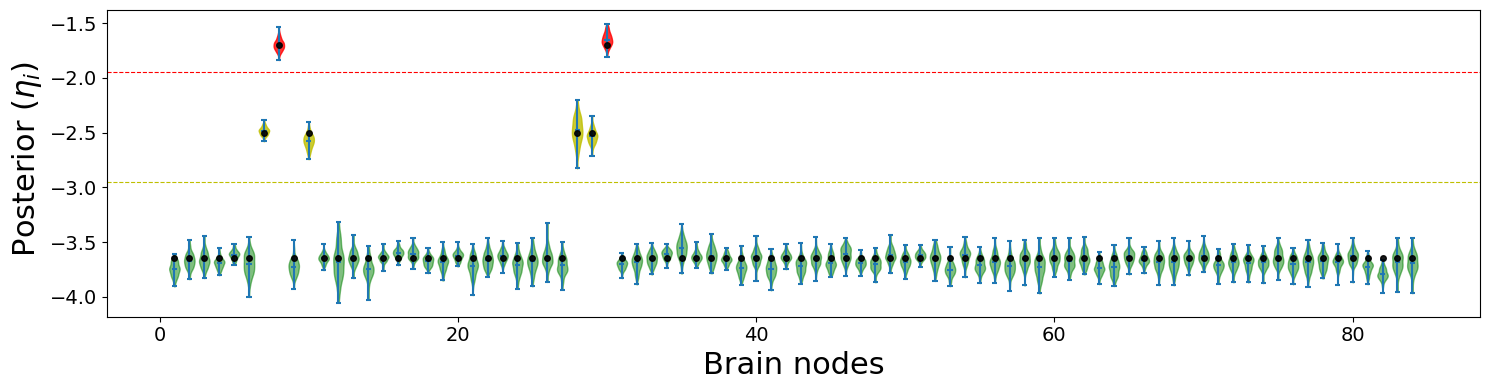

In [141]:
plt.figure(figsize=(15,4))
SEM_violinplot(nn, eta_true, ez_idx, pz_idx, eta_posterior, eta_c, delta_eta )
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"SBI_BVEP_ode_obs2_InferredExcitability_K_"+str(K_true)+".png"), dpi=800)
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"SBI_BVEP_ode_obs2_InferredExcitability_K_"+str(K_true)+".svg"), dpi=800)
plt.show()

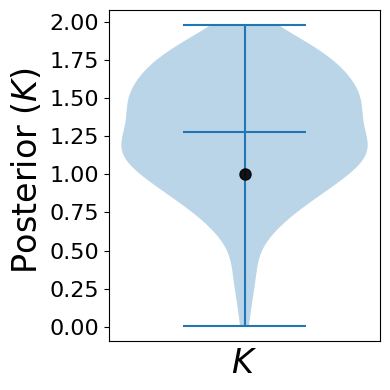

In [142]:
plt.figure(figsize=(4,4))
parts= plt.violinplot(K_posterior, widths=0.7, showmeans=True, showextrema=True);
plt.plot(1,params_true[-1] ,'o', color='k', alpha=0.9, markersize=8)
plt.ylabel(' Posterior ' +r'${(K)}$', fontsize=24);
plt.xlabel(r'${K}$', fontsize=24);
plt.yticks(fontsize=16)
plt.xticks([])
plt.tight_layout()
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"SBI_BVEP_ode_obs2_InferredCoupling_K_"+str(K_true)+".png"), dpi=800)
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"SBI_BVEP_ode_obs2_InferredCoupling_K_"+str(K_true)+".svg"), dpi=800)
plt.show()

In [143]:
estimated_posterior=np.percentile(posterior_samples, [50], axis=0).reshape(-1)

In [144]:
y_fit_source =VEP2Dmodel(estimated_posterior, constants, init_conditions, dt, ts, SC)

yfit_source=y_fit_source.reshape(nn, int(y_fit_source.shape[0]/nn))


In [145]:
y_fit=yfit_source
y_fit.shape

(84, 141)

In [146]:
np.save(os.path.join(cwd+'/'+str(Res_dir), 'BVEP_ode_sbi_sourcelevel_obs2_patient1_y_obs.npy') , y_obs)
np.save(os.path.join(cwd+'/'+str(Res_dir), 'BVEP_ode_sbi_sourcelevel_obs2_patient1_y_fit.npy') , y_fit)

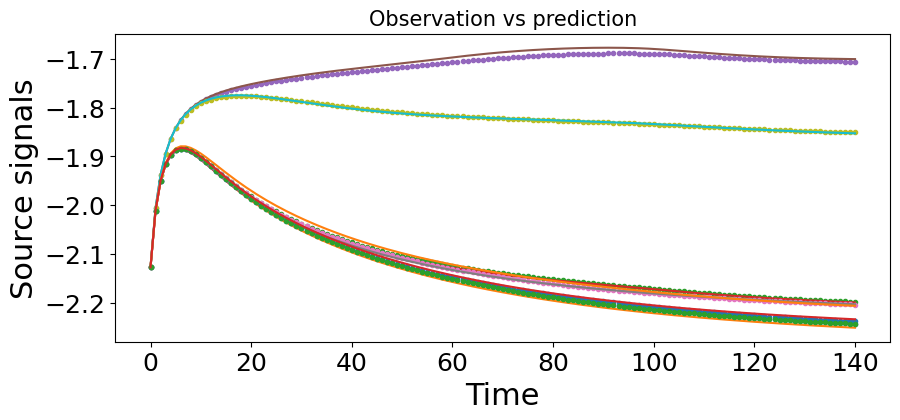

In [147]:
Rois=np.array([1, 5, 6, 11, 27, 34, 50])

plt.figure(figsize=(10,4))
for roi in Rois:
    plt.plot(y_obs.T[:,roi], '.')
    plt.plot(y_fit.T[:,roi] )
plt.title("Observation vs prediction",fontsize=15)
plt.xlabel('Time', fontsize=22)
plt.ylabel('Source signals', fontsize=22)
plt.yticks(fontsize=18, rotation=0)
plt.xticks(fontsize=18, rotation=0)
plt.show()

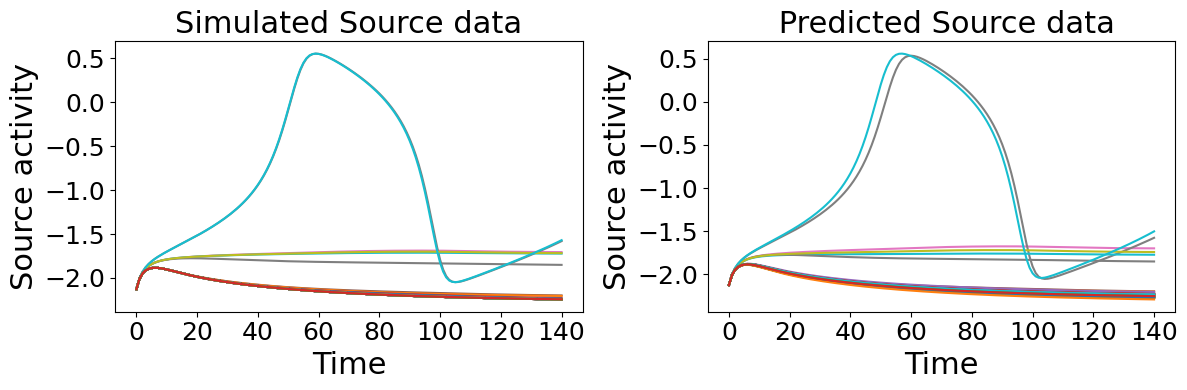

In [148]:
plt.figure(figsize=(12,4))

plt.subplot(121);
plt.plot(y_obs.T)
plt.title("Simulated Source data", fontsize=22)
plt.xlabel('Time', fontsize=22)
plt.ylabel('Source activity', fontsize=22)
plt.yticks(fontsize=18, rotation=0)
plt.xticks(fontsize=18, rotation=0)

plt.subplot(122)
plt.plot(y_fit.T)
plt.title(" Predicted Source data", fontsize=22)
plt.xlabel('Time', fontsize=22)
plt.ylabel('Source activity', fontsize=22)
plt.yticks(fontsize=18, rotation=0)
plt.xticks(fontsize=18, rotation=0)
plt.tight_layout()
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"SBI_FittedBVEP_ode_obs2_observation_K_"+str(K_true)+".png"), dpi=800)
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"SBI_FittedBVEP_ode_obs2_observation_K_"+str(K_true)+".svg"), dpi=800)
plt.show()

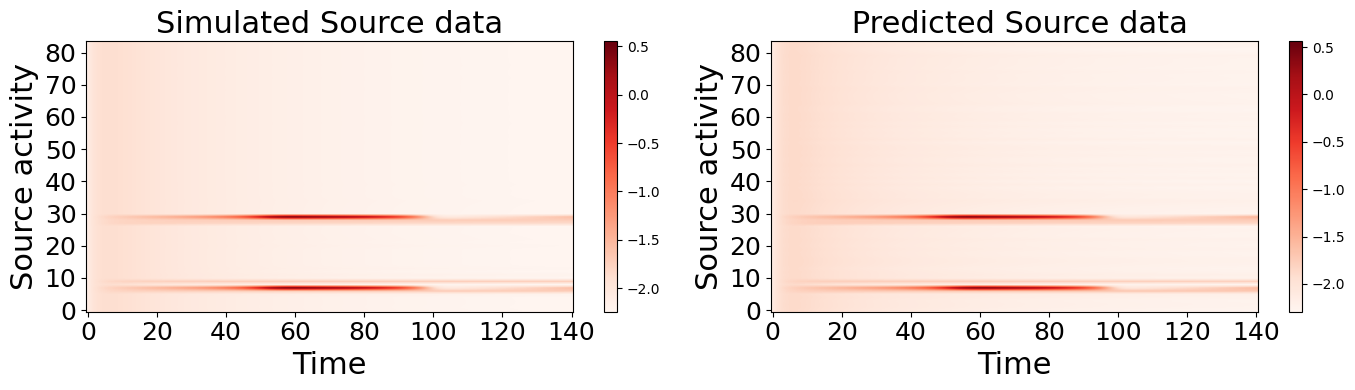

In [149]:
plt.figure(figsize=(14, 4))
plt.subplot(121);
plt.imshow(y_obs, aspect='auto', interpolation='bilinear',  origin='lower', cmap='Reds')
plt.title("Simulated Source data", fontsize=22)
plt.xlabel('Time', fontsize=22)
plt.ylabel('Source activity', fontsize=22)
plt.yticks(fontsize=18, rotation=0)
plt.xticks(fontsize=18, rotation=0)
plt.colorbar();

plt.subplot(122)
plt.imshow(y_fit, aspect='auto', interpolation='bilinear',  origin='lower', cmap='Reds')
plt.title(" Predicted Source data", fontsize=22)
plt.xlabel('Time', fontsize=22)
plt.ylabel('Source activity', fontsize=22)
plt.yticks(fontsize=18, rotation=0)
plt.xticks(fontsize=18, rotation=0)
plt.colorbar();

plt.tight_layout()
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"SBI_ImshowFittedBVEP_ode_obs2_observation_K_"+str(K_true)+".png"), dpi=800)
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"SBI_ImshowFittedBVEP_ode_obs2_observation_K_"+str(K_true)+".svg"), dpi=800)
plt.show()

In [150]:
eta_true.shape, eta_posterior.shape

((84,), (200, 84))

In [151]:
true_labels_nodes,est_labels_nodes =SME_labels(eta_true, eta_posterior.transpose(), eta_c, delta_eta)

In [152]:
Confusion_matrix_values= confusion_matrix(true_labels_nodes, est_labels_nodes, labels=["EZ", "PZ", "HZ"])
print('Confusion_matrix_values= \n', Confusion_matrix_values)

Confusion_matrix_values= 
 [[ 2  0  0]
 [ 0  4  0]
 [ 0  0 78]]


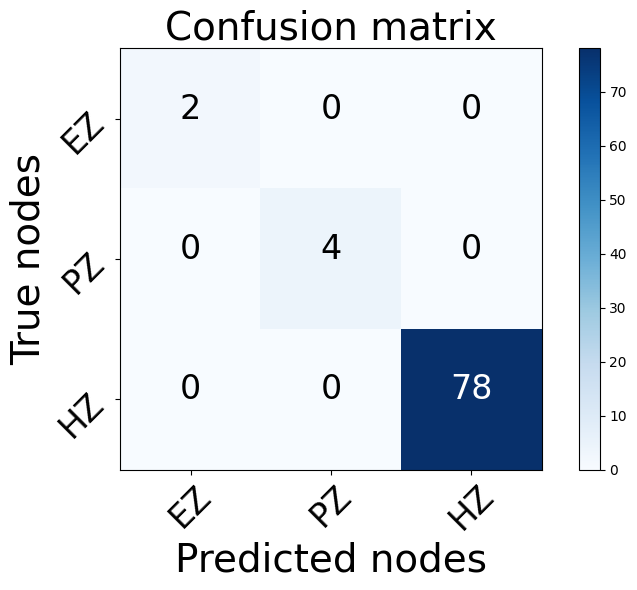

In [153]:
plt.figure(figsize=(8, 6))
plot_confusion_matrix(Confusion_matrix_values, ["EZ", "PZ", "HZ"])
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"SBI_BVEP_ode_obs2_ConfusionMatrix_K_"+str(K_true)+".png"), dpi=800)
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"SBI_BVEP_ode_obs2_ConfusionMatrix_K_"+str(K_true)+".svg"), dpi=800)
plt.tight_layout()
plt.show()

In [154]:
np.sum(np.std(eta_posterior, axis=0))

np.float32(5.44898)

In [155]:
from report_metrics import LSE, Err, RMSE, LSE_obs, z_score, shrinkage

In [156]:
eta_est_mu=np.mean(eta_posterior, axis=0)
eta_est_std=np.std(eta_posterior, axis=0)

In [157]:
b=-7
a=-1
prior_std =np.sqrt((1/12)*(b-a)**2)

In [158]:
def plot_zscore_shrinkage(nodes, eta_true, eta_est_mu, eta_est_std, prior_std):
    z_score_eta=z_score(eta_true, eta_est_mu, eta_est_std)
    colors= np.random.rand(z_score_eta.shape[0])
    plt.scatter(shrinkage([prior_std]*nodes.shape[0], eta_est_std), z_score_eta ,s=120, c='blue')
    plt.xlabel("Posterior shrinkages", fontsize=24)
    plt.ylabel("Posterior z-scores", fontsize=24)
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)

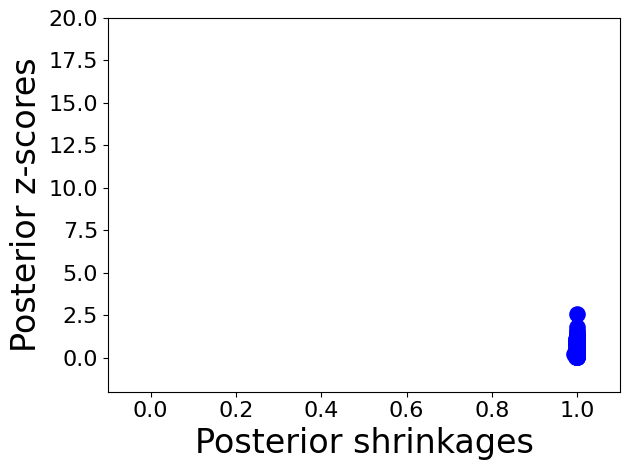

In [159]:
plot_zscore_shrinkage(nodes, eta_true, eta_est_mu, eta_est_std, prior_std)
plt.axis((-.1,1.1,-2,20))
plt.tight_layout()
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"SBI_BVEP_ode_obs2_zscore_shrinkage_K_"+str(K_true)+".png"), dpi=800)
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"SBI_BVEP_ode_obs2_zscore_shrinkage_K_"+str(K_true)+".svg"), dpi=800)
plt.show()

In [160]:
Err(eta_true, eta_est_mu), RMSE(eta_true, eta_est_mu)

(np.float64(3.192456960678103), np.float64(0.04779316336746985))

In [161]:
Err(y_obs, y_fit), RMSE(y_obs, y_fit)

(np.float64(129.86130382409894), np.float64(0.018897575865942068))

In [162]:
shrinkage([prior_std]*nodes.shape[0], eta_est_std).shape

(84,)

In [163]:
from sklearn import metrics
from itertools import cycle
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_recall_curve
from sklearn.preprocessing import label_binarize

In [164]:
n_classes=3
node_classes=['HZ', 'PZ', 'EZ']

In [165]:
true_nodes=true_node_binary(true_labels_nodes)
estimated_nodes=estimated_node_binary(est_labels_nodes)

In [166]:
y_true=label_binarize(true_nodes, classes=[0, 1, 2])
y_pred=label_binarize(estimated_nodes, classes=[0, 1, 2])

In [167]:
y_true.shape, y_pred.shape

((84, 3), (84, 3))

In [168]:
fpr = dict()
tpr = dict()
roc_auc = dict()


for i in range(n_classes):
    fpr[i], tpr[i], _ = metrics.roc_curve(y_true[:, i], y_pred[:, i])
    roc_auc[i] = metrics.auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = metrics.roc_curve(y_true.ravel(), y_pred.ravel())
roc_auc["micro"] = metrics.auc(fpr["micro"], tpr["micro"])


all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = metrics.auc(fpr["macro"], tpr["macro"])

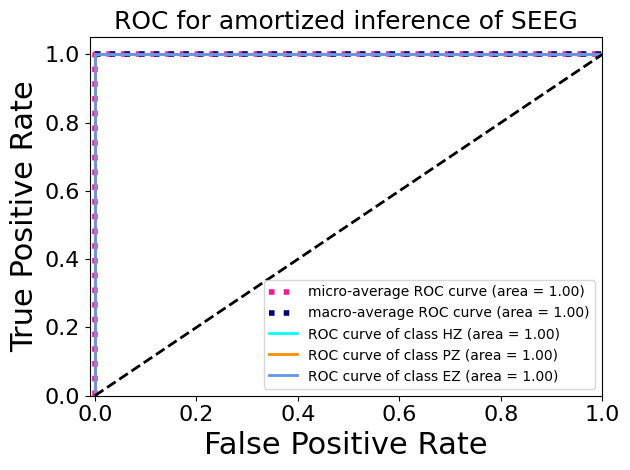

In [169]:
# Plot all ROC curves
plt.figure()
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class '+ str(node_classes[i])+' (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([-.01, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=22)
plt.ylabel('True Positive Rate', fontsize=22)
plt.title('ROC for amortized inference of SEEG', fontsize=18)
plt.legend(loc="lower right")
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.tight_layout()
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"ROC_obs2_K_"+str(K_true)+".png"), dpi=800)
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"ROC_obs2_K_"+str(K_true)+".png"), dpi=800)
plt.show()

In [170]:
fpr

{0: array([0., 0., 1.]),
 1: array([0., 0., 1.]),
 2: array([0., 0., 1.]),
 'micro': array([0., 0., 1.]),
 'macro': array([0., 1.])}

In [171]:
tpr

{0: array([0., 1., 1.]),
 1: array([0., 1., 1.]),
 2: array([0., 1., 1.]),
 'micro': array([0., 1., 1.]),
 'macro': array([1., 1.])}

In [172]:
roc_auc["micro"], roc_auc["macro"]

(np.float64(1.0), np.float64(1.0))

### Another Data set

In [173]:
hz_val=-3.65
pz_val=-2.4
ez_val=-1.6

ez_idx = np.array([6, 34, 18, 45, 67, 81],  dtype=np.int32)
pz_wplng_idx = np.array([5,11], dtype=np.int32)
pz_kplng_idx = np.array([27], dtype=np.int32)
pz_idx = np.append(pz_kplng_idx, pz_wplng_idx)

In [174]:
eta_true = np.ones(nn)*hz_val
eta_true[ez_idx] = ez_val
eta_true[pz_idx] = pz_val

In [175]:
K_true=1.

In [176]:
x_init=-2.5
z_init=3.5
init_conditions = np.array([x_init, z_init])

In [177]:
params_true = np.append(eta_true, K_true)
params_true.shape

(85,)

In [178]:
obs_source =VEP2Dmodel(params_true, constants, init_conditions, dt, ts, SC)
obs_source=obs_source.reshape(nn, int(obs_source.shape[0]/nn))

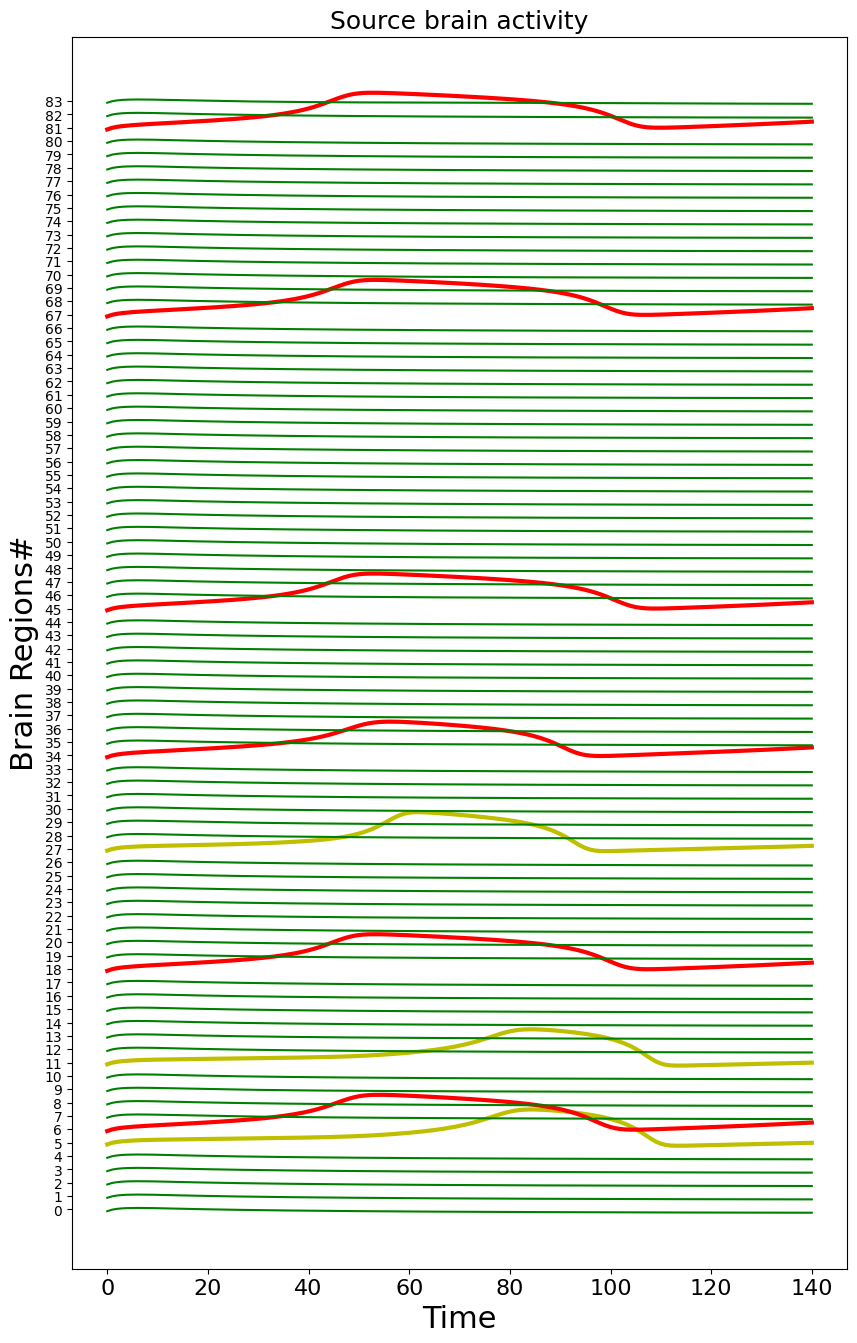

In [179]:
plt.figure(figsize=(10,16))
for i in range(0, nn):
    if i in ez_idx:
          plt.plot(obs_source[i,:]+i, 'r', lw=3)
    elif i in pz_idx:
          plt.plot(obs_source[i,:]+i, 'y', lw=3)
    else:
          plt.plot(obs_source[i,:]+i, 'g')
plt.yticks(np.r_[0:nn]-2, np.r_[0:nn],fontsize=10)
plt.xticks(fontsize=16)
plt.title("Source brain activity",fontsize=18)
plt.xlabel('Time',fontsize=22)
plt.ylabel('Brain Regions#',fontsize=22)
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"SBI_BVEP_ode_obs3_source_K_"+str(K_true)+".png"), dpi=800)
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"SBI_BVEP_ode_obs3_source_K_"+str(K_true)+".svg"), dpi=800)
plt.show()

In [180]:
obs_summary_statistics=calculate_summary_statistics_features(obs_source.reshape(-1),  nn, nt, dt, ts, features=['seizures_onset'])

In [181]:
obs_source.shape, obs_summary_statistics.shape

((84, 141), (588,))

In [182]:
y_obs=obs_source
y_obs.shape

(84, 141)

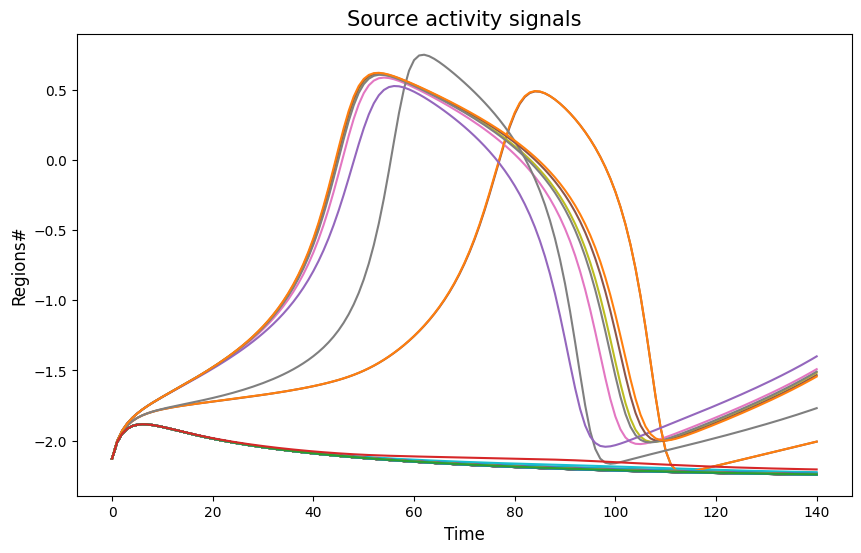

In [183]:
plt.figure(figsize=(10,6))
plt.plot(obs_source.T)
plt.title("Source activity signals",fontsize=15)
plt.xlabel('Time',fontsize=12)
plt.ylabel('Regions#',fontsize=12)
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"SBI_BVEP_ode_obs3_seeg_K_"+str(K_true)+".png"), dpi=800)
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"SBI_BVEP_ode_obs3_seeg_K_"+str(K_true)+".svg"), dpi=800)

### Posterior

In [184]:
nodes=np.r_[0:nn]

In [185]:
num_samples=200

In [186]:
start_time = time.time()

posterior_samples = posterior.sample((num_samples,), obs_summary_statistics).numpy()

print ("-"*60)
print("--- sampling took: %s seconds ---" % (time.time() - start_time))

Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

------------------------------------------------------------
--- sampling took: 0.805931568145752 seconds ---


In [187]:
posterior_samples.shape, params_true.shape

((200, 85), (85,))

In [188]:
np.save(os.path.join(cwd+'/'+str(Res_dir), 'BVEP_ode_sbi_sourcelevel_obs3_patient1_posteriorsamples.npy') , posterior_samples)

In [189]:
eta_posterior=posterior_samples[:,:-1]
K_posterior=posterior_samples[:,-1]

In [190]:
K_posterior.mean(), K_posterior.std()

(np.float32(1.1838596), np.float32(0.38839552))

In [191]:
eta_c=-1.95
delta_eta=1.0

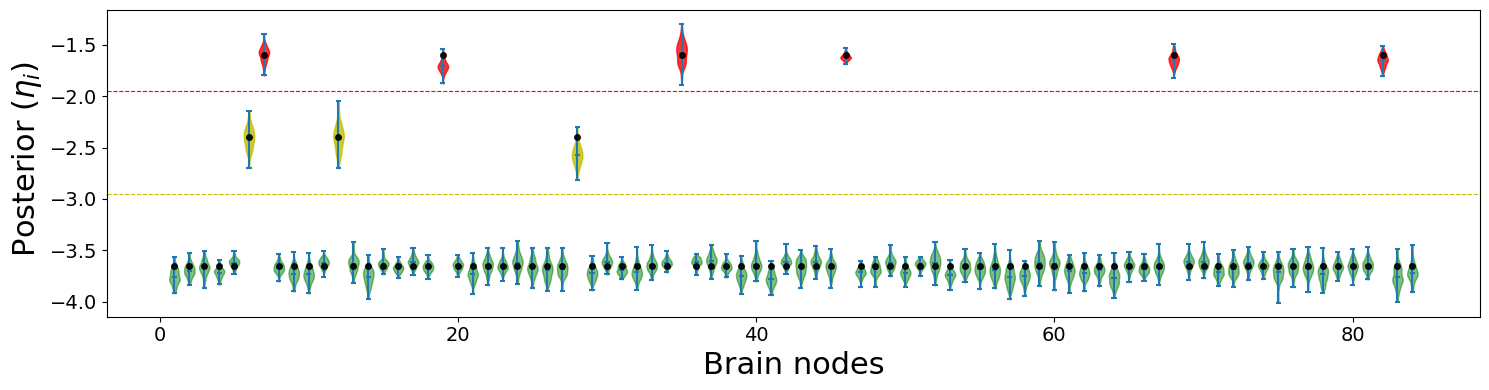

In [192]:
plt.figure(figsize=(15,4))
SEM_violinplot(nn, eta_true, ez_idx, pz_idx, eta_posterior, eta_c, delta_eta )
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"SBI_BVEP_ode_obs3_InferredExcitability_K_"+str(K_true)+".png"), dpi=800)
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"SBI_BVEP_ode_obs3_InferredExcitability_K_"+str(K_true)+".svg"), dpi=800)
plt.show()

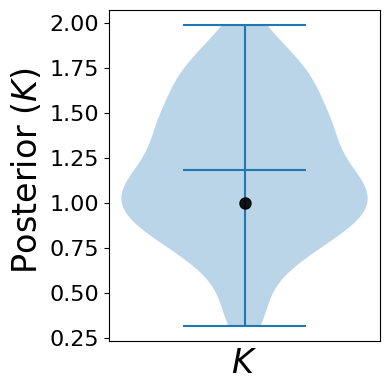

In [193]:
plt.figure(figsize=(4,4))
parts= plt.violinplot(K_posterior, widths=0.7, showmeans=True, showextrema=True);
plt.plot(1,params_true[-1] ,'o', color='k', alpha=0.9, markersize=8)
plt.ylabel(' Posterior ' +r'${(K)}$', fontsize=24);
plt.xlabel(r'${K}$', fontsize=24);
plt.yticks(fontsize=16)
plt.xticks([])
plt.tight_layout()
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"SBI_BVEP_ode_obs3_InferredCoupling_K_"+str(K_true)+".png"), dpi=800)
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"SBI_BVEP_ode_obs3_InferredCoupling_K_"+str(K_true)+".svg"), dpi=800)
plt.show()

In [194]:
estimated_posterior=np.percentile(posterior_samples, [50], axis=0).reshape(-1)

In [195]:
y_fit_source =VEP2Dmodel(estimated_posterior, constants, init_conditions, dt, ts, SC)

yfit_source=y_fit_source.reshape(nn, int(y_fit_source.shape[0]/nn))

In [196]:
y_fit=yfit_source
y_fit.shape

(84, 141)

In [197]:
np.save(os.path.join(cwd+'/'+str(Res_dir), 'BVEP_ode_sbi_sourcelevel_obs3_patient1_y_obs.npy') , y_obs)
np.save(os.path.join(cwd+'/'+str(Res_dir), 'BVEP_ode_sbi_sourcelevel_obs3_patient1_y_obs.npy') , y_fit)

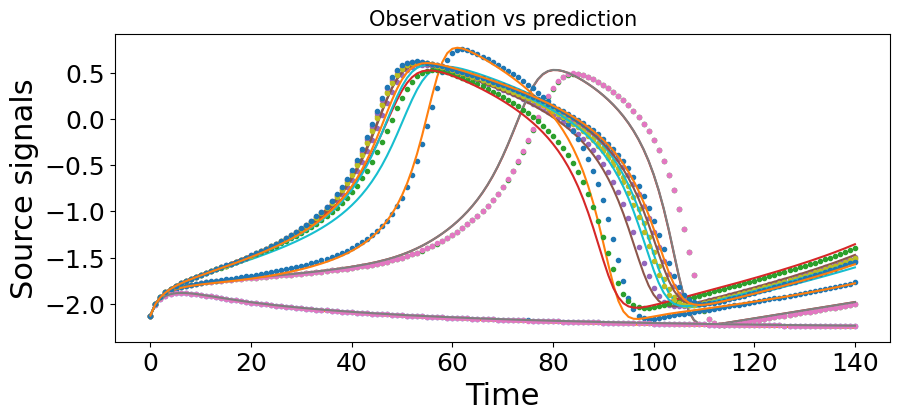

In [198]:
Rois=np.array([1, 5, 6, 11,18,  27, 34, 45, 50, 67, 81])

plt.figure(figsize=(10,4))
for roi in Rois:
    plt.plot(y_obs.T[:,roi], '.')
    plt.plot(y_fit.T[:,roi] )
plt.title("Observation vs prediction",fontsize=15)
plt.xlabel('Time', fontsize=22)
plt.ylabel('Source signals', fontsize=22)
plt.yticks(fontsize=18, rotation=0)
plt.xticks(fontsize=18, rotation=0)
plt.show()

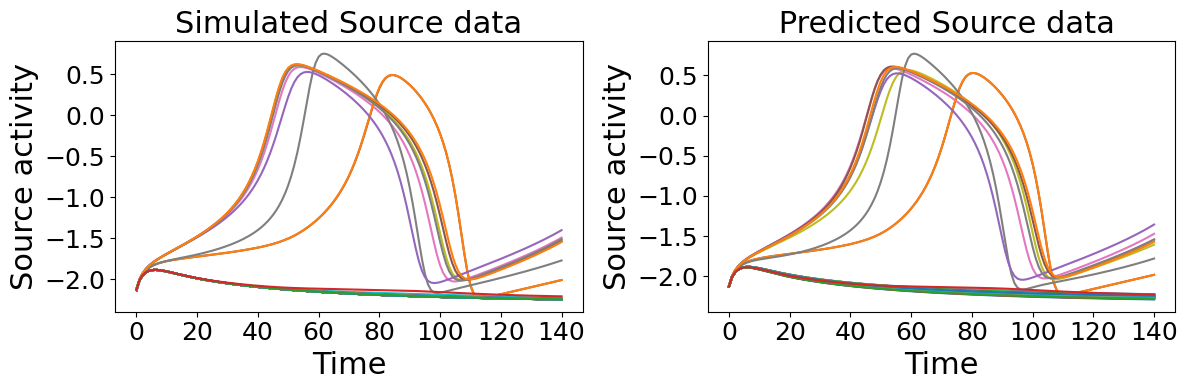

In [199]:
plt.figure(figsize=(12,4))

plt.subplot(121);
plt.plot(y_obs.T)
plt.title("Simulated Source data", fontsize=22)
plt.xlabel('Time', fontsize=22)
plt.ylabel('Source activity', fontsize=22)
plt.yticks(fontsize=18, rotation=0)
plt.xticks(fontsize=18, rotation=0)

plt.subplot(122)
plt.plot(y_fit.T)
plt.title(" Predicted Source data", fontsize=22)
plt.xlabel('Time', fontsize=22)
plt.ylabel('Source activity', fontsize=22)
plt.yticks(fontsize=18, rotation=0)
plt.xticks(fontsize=18, rotation=0)
plt.tight_layout()
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"SBI_FittedBVEP_ode_obs3_observation_K_"+str(K_true)+".png"), dpi=800)
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"SBI_FittedBVEP_ode_obs3_observation_K_"+str(K_true)+".svg"), dpi=800)
plt.show()

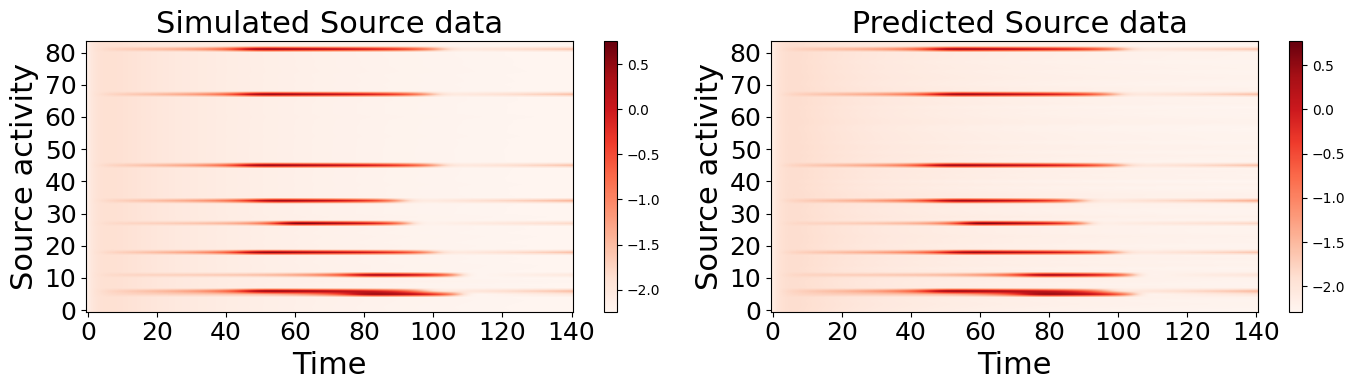

In [200]:
plt.figure(figsize=(14, 4))
plt.subplot(121);
plt.imshow(y_obs, aspect='auto', interpolation='bilinear',  origin='lower', cmap='Reds')
plt.title("Simulated Source data", fontsize=22)
plt.xlabel('Time', fontsize=22)
plt.ylabel('Source activity', fontsize=22)
plt.yticks(fontsize=18, rotation=0)
plt.xticks(fontsize=18, rotation=0)
plt.colorbar();

plt.subplot(122)
plt.imshow(y_fit, aspect='auto', interpolation='bilinear',  origin='lower', cmap='Reds')
plt.title(" Predicted Source data", fontsize=22)
plt.xlabel('Time', fontsize=22)
plt.ylabel('Source activity', fontsize=22)
plt.yticks(fontsize=18, rotation=0)
plt.xticks(fontsize=18, rotation=0)
plt.colorbar();

plt.tight_layout()
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"SBI_ImshowFittedBVEP_ode_obs3_observation_K_"+str(K_true)+".png"), dpi=800)
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"SBI_ImshowFittedBVEP_ode_obs3_observation_K_"+str(K_true)+".svg"), dpi=800)
plt.show()

In [201]:
eta_true.shape, eta_posterior.shape

((84,), (200, 84))

In [202]:
true_labels_nodes,est_labels_nodes =SME_labels(eta_true, eta_posterior.transpose(), eta_c, delta_eta)

In [203]:
Confusion_matrix_values= confusion_matrix(true_labels_nodes, est_labels_nodes, labels=["EZ", "PZ", "HZ"])
print('Confusion_matrix_values= \n', Confusion_matrix_values)

Confusion_matrix_values= 
 [[ 6  0  0]
 [ 0  3  0]
 [ 0  0 75]]


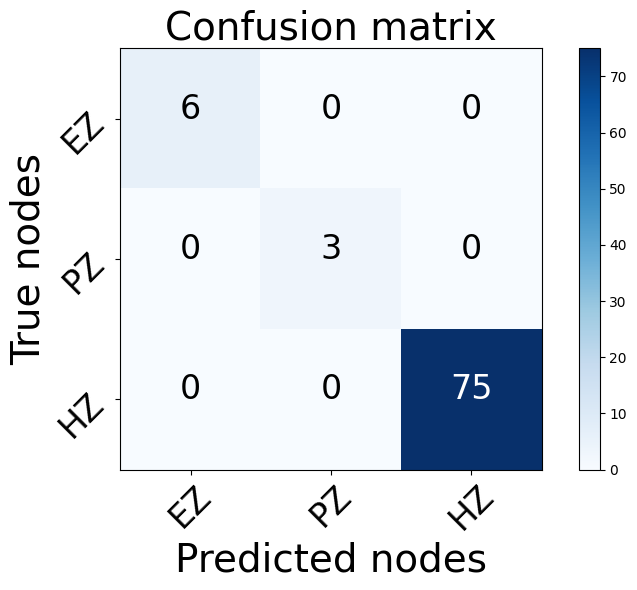

In [204]:
plt.figure(figsize=(8, 6))
plot_confusion_matrix(Confusion_matrix_values, ["EZ", "PZ", "HZ"])
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"SBI_BVEP_ode_obs3_ConfusionMatrix_K_"+str(K_true)+".png"), dpi=800)
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"SBI_BVEP_ode_obs3_ConfusionMatrix_K_"+str(K_true)+".svg"), dpi=800)
plt.tight_layout()
plt.show()

In [205]:
np.sum(np.std(eta_posterior, axis=0))

np.float32(5.3649178)

In [206]:
from report_metrics import LSE, Err, RMSE, LSE_obs, z_score, shrinkage

In [207]:
eta_est_mu=np.mean(eta_posterior, axis=0)
eta_est_std=np.std(eta_posterior, axis=0)

In [208]:
b=-7
a=-1
prior_std =np.sqrt((1/12)*(b-a)**2)

In [209]:
def plot_zscore_shrinkage(nodes, eta_true, eta_est_mu, eta_est_std, prior_std):
    z_score_eta=z_score(eta_true, eta_est_mu, eta_est_std)
    colors= np.random.rand(z_score_eta.shape[0])
    plt.scatter(shrinkage([prior_std]*nodes.shape[0], eta_est_std), z_score_eta ,s=120, c='blue')
    plt.xlabel("Posterior shrinkages", fontsize=24)
    plt.ylabel("Posterior z-scores", fontsize=24)
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)

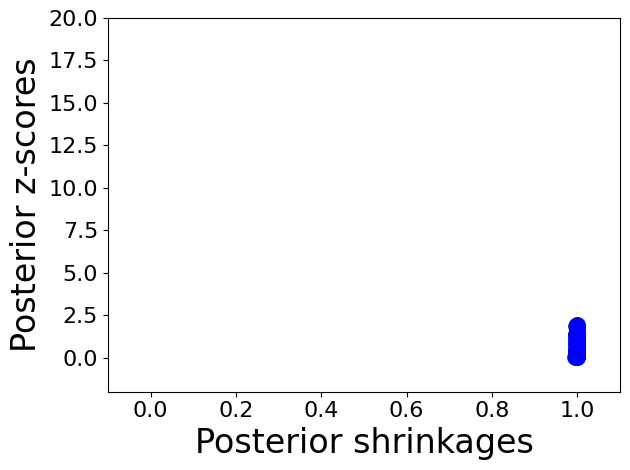

In [210]:
plot_zscore_shrinkage(nodes, eta_true, eta_est_mu, eta_est_std, prior_std)
plt.axis((-.1,1.1,-2,20))
plt.tight_layout()
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"SBI_BVEP_ode_obs3_zscore_shrinkage_K_"+str(K_true)+".png"), dpi=800)
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"SBI_BVEP_ode_obs3_zscore_shrinkage_K_"+str(K_true)+".svg"), dpi=800)
plt.show()

In [211]:
Err(eta_true, eta_est_mu), RMSE(eta_true, eta_est_mu)

(np.float64(3.5276241540908835), np.float64(0.05498436305326661))

In [212]:
Err(y_obs, y_fit), RMSE(y_obs, y_fit)

(np.float64(190.8833462015222), np.float64(0.044130288282525944))

In [213]:
shrinkage([prior_std]*nodes.shape[0], eta_est_std).shape

(84,)

In [214]:
n_classes=3
node_classes=['HZ', 'PZ', 'EZ']

In [215]:
from sklearn import metrics
from itertools import cycle
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_recall_curve
from sklearn.preprocessing import label_binarize

In [216]:
true_nodes=true_node_binary(true_labels_nodes)
estimated_nodes=estimated_node_binary(est_labels_nodes)

In [217]:
y_true=label_binarize(true_nodes, classes=[0, 1, 2])
y_pred=label_binarize(estimated_nodes, classes=[0, 1, 2])

In [218]:
y_true.shape, y_pred.shape

((84, 3), (84, 3))

In [219]:
fpr = dict()
tpr = dict()
roc_auc = dict()


for i in range(n_classes):
    fpr[i], tpr[i], _ = metrics.roc_curve(y_true[:, i], y_pred[:, i])
    roc_auc[i] = metrics.auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = metrics.roc_curve(y_true.ravel(), y_pred.ravel())
roc_auc["micro"] = metrics.auc(fpr["micro"], tpr["micro"])


all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = metrics.auc(fpr["macro"], tpr["macro"])

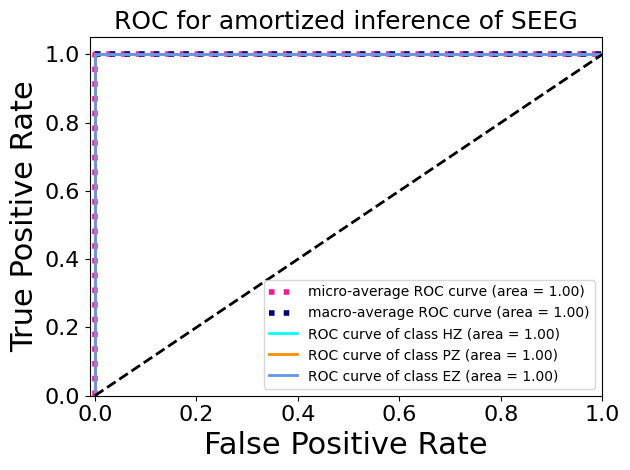

In [220]:
# Plot all ROC curves
plt.figure()
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class '+ str(node_classes[i])+' (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([-.01, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=22)
plt.ylabel('True Positive Rate', fontsize=22)
plt.title('ROC for amortized inference of SEEG', fontsize=18)
plt.legend(loc="lower right")
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.tight_layout()
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"ROC_obs3_K_"+str(K_true)+".png"), dpi=800)
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"ROC_obs3_K_"+str(K_true)+".png"), dpi=800)
plt.show()

In [221]:
fpr

{0: array([0., 0., 1.]),
 1: array([0., 0., 1.]),
 2: array([0., 0., 1.]),
 'micro': array([0., 0., 1.]),
 'macro': array([0., 1.])}

In [222]:
tpr

{0: array([0., 1., 1.]),
 1: array([0., 1., 1.]),
 2: array([0., 1., 1.]),
 'micro': array([0., 1., 1.]),
 'macro': array([1., 1.])}

In [223]:
roc_auc["micro"], roc_auc["macro"]

(np.float64(1.0), np.float64(1.0))